In [111]:
import pandas as pd
import pickle
import dask.dataframe as dd

import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

import subprocess

In [112]:
blocks_to_plot = pd.read_csv('../wza/blocks_to_plot.csv')

In [114]:
dict_blocks = '../key_files/blocks_snpsid_dict.pkl'

with open(dict_blocks, 'rb') as file:
    dict_blocks = pickle.load(file)

reverse_mapping = {item: key for key, values in dict_blocks.items() for item in values}

In [115]:
snps_dict = pd.read_csv('../key_files/var_pos_grenenet.csv')

In [116]:
snps_dict['block'] = snps_dict['id'].map(reverse_mapping)

In [117]:
snps_dict_filt = snps_dict[snps_dict['block'].isin(blocks_to_plot['block'].values)]

In [118]:
awk_conditions = []

for i in blocks_to_plot['block'].values:
    start_idx = snps_dict[snps_dict['block'].isin([i])].index.values[0] + 2  # Adjusting the start index
    end_idx = snps_dict[snps_dict['block'].isin([i])].index.values[-1] + 2 # Adjusting the end index
    awk_conditions.append(f"NR >= {start_idx} && NR <= {end_idx}")  # Convert integers to strings inside f-string


# Join the conditions with ' || ' to match the awk syntax
awk_filter = ' || '.join(awk_conditions)

# Construct the final awk command
awk_command = f"awk '{awk_filter}' ../baypass_terminal/merged_hapFIRE_allele_frequency_indexed.csv > af_blocks_to_plot.csv"

# Run the command using subprocess
subprocess.run(awk_command, shell=True, check=True)

CompletedProcess(args="awk 'NR >= 1594026 && NR <= 1594087 || NR >= 232556 && NR <= 232721 || NR >= 784658 && NR <= 784666 || NR >= 513379 && NR <= 513484 || NR >= 1668247 && NR <= 1668261 || NR >= 1628868 && NR <= 1628926 || NR >= 1625940 && NR <= 1626013 || NR >= 1350494 && NR <= 1350645 || NR >= 763398 && NR <= 763657 || NR >= 739175 && NR <= 739679 || NR >= 1121076 && NR <= 1126169 || NR >= 129756 && NR <= 133333 || NR >= 3053517 && NR <= 3053587 || NR >= 1396836 && NR <= 1396883 || NR >= 1880482 && NR <= 1880563 || NR >= 1066057 && NR <= 1066322 || NR >= 1181471 && NR <= 1181493 || NR >= 82229 && NR <= 82282 || NR >= 249326 && NR <= 249417 || NR >= 700233 && NR <= 700421' ../baypass_terminal/merged_hapFIRE_allele_frequency_indexed.csv > af_blocks_to_plot.csv", returncode=0)

In [119]:
#awk 'NR >= 845212 && NR <= 845232 || NR >= 1868509 && NR <= 1868608 || NR >= 3053517 && NR <= 3053587' ../baypass_terminal/merged_hapFIRE_allele_frequency_indexed.csv > filtered_blocks.csv

In [120]:
#awk 'NR >= 845212 && NR <= 845232 || NR >= 1868509 && NR <= 1868608 || NR >= 3053517 && NR <= 3053587' ../key_files/merged_hapFIRE_delta_p.txt > filtered_blocks_deltap.csv

In [121]:
## allele counts
af = pd.read_csv('af_blocks_to_plot.csv',header=None)
usecols = pd.read_csv('../baypass_terminal/merged_hapFIRE_allele_frequency_indexed.csv',nrows =1).columns 
af.columns = usecols

In [122]:
snps_dict_filt = snps_dict_filt.reset_index(drop=True)

In [123]:
causal = pd.concat([af, snps_dict_filt],axis=1)

In [124]:
causal = causal[causal['total_alleles05filter'].notna()]

causal_det = causal[['pos', 'chrom', 'maf05filter', 'total_alleles05filter', 'block']].copy()

causal =causal.drop(['pos', 'chrom', 'maf05filter', 'total_alleles05filter', 'block'],axis=1).set_index('id')

In [125]:
first_gen = pd.read_csv('../key_files/generation_1_sample_names.txt',header=None)[0]

In [126]:
causal_first_gen = causal[first_gen]

In [127]:
causal_loci_save = causal.index

In [128]:
causal_values = causal_first_gen.reset_index().drop(columns='id').T

In [129]:
samples = causal_first_gen.columns

#clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')
clim_sites_during_exp = pd.read_csv('../key_files/bioclimvars_sites_era5_year_2018.csv')

sites_af = pd.Series(samples).str.split('_').str[0].astype(int)

sites_af.name = 'site'

env = sites_af.reset_index().merge(clim_sites_during_exp).drop(['index'],axis=1)

bio1 = env['bio1']

In [130]:
bio1.index = causal_values.index

In [131]:
bio1

1_1_1      10.209418
1_1_2      10.209418
1_1_3      10.209418
1_1_4      10.209418
1_1_5      10.209418
             ...    
60_1_8     18.908464
60_1_9     18.908464
60_1_10    18.908464
60_1_11    18.908464
60_1_12    18.908464
Name: bio1, Length: 326, dtype: float64

In [132]:
blocks_ids = blocks_to_plot['block'].unique()

In [133]:
len(blocks_ids)

20

In [134]:
colors = sns.color_palette("viridis", n_colors = len(blocks_ids))

# Create a dictionary that maps each block to a specific color
block_color_dict = {block: color for block, color in zip(blocks_ids, itertools.cycle(colors))}

In [135]:
causal_det = causal_det.reset_index(drop=True)

In [136]:
causal_det

pos  chrom maf05filter total_alleles05filter   block
0      3996587      1   1_3996587             1_3996587   1_485
1      3996589      1   1_3996589             1_3996589   1_485
2      3996661      1   1_3996661             1_3996661   1_485
3      3996815      1   1_3996815             1_3996815   1_485
4      3996828      1   1_3996828             1_3996828   1_485
...        ...    ...         ...                   ...     ...
4454  19685399      5  5_19685399            5_19685399  5_2244
4455  19685425      5  5_19685425            5_19685425  5_2244
4456  19685431      5  5_19685431            5_19685431  5_2244
4457  19685451      5  5_19685451            5_19685451  5_2244
4458  19685484      5  5_19685484            5_19685484  5_2244

[4459 rows x 5 columns]

In [137]:
causal_det['block'].unique()

array(['1_485', '1_702', '1_1555', '1_1594', '1_2834', '1_4505', '1_4832',
       '1_4969', '1_5039', '2_827', '2_970', '2_1265', '2_2050', '3_133',
       '3_1103', '3_1280', '3_1308', '3_1463', '3_2855', '5_2244'],
      dtype=object)

In [138]:
neutral_unique_blocks = blocks_to_plot[blocks_to_plot['type'] =='neutral']['block'].unique()

In [139]:
neutral_unique_blocks

array(['3_1103', '1_1555', '1_5039', '1_2834', '3_1463', '3_1308',
       '3_1280', '2_2050', '1_4969', '1_4832'], dtype=object)

In [140]:
neutral_unique_blocks[0]

'3_1103'

In [141]:
import numpy as np
bio1 = np.log(bio1)

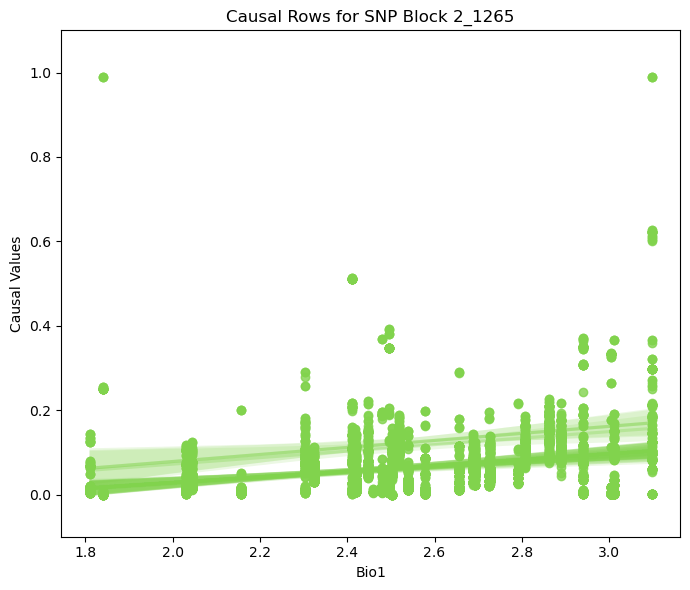

In [142]:
# Identify unique blocks from your data
unique_blocks = ['2_1265']

# Create subplots: one for each unique block
fig, axes = plt.subplots(nrows=len(unique_blocks), figsize=(7, 6 * len(unique_blocks)), sharex=True,sharey=True)

# If there's only one unique block, `axes` will not be an array, so we make it one
if len(unique_blocks) == 1:
    axes = [axes]

# Plot each row of causal as a line in the corresponding subplot
for i, block in enumerate(unique_blocks):
    # Filter the rows corresponding to the current block
    block_rows = causal_det[causal_det['block'] == block].index
    color = block_color_dict[block]
    
    for row in block_rows:
        # Perform linear regression between bio1 and the current row of causal values        
        # Plot the causal values for this row
        sns.regplot(x=bio1, y=causal_values[row], ax=axes[i], label=f'Row {row + 1}', color=color,
                    line_kws={"alpha": 0.3})  # scatter_kws={'s': 50}, 
        
        # Annotate the plot with the R-squared value
    
    # Set labels and title for each subplot
    axes[i].set_title(f'Causal Rows for SNP Block {block}')
    axes[i].set_xlabel('Bio1')
    axes[i].set_ylabel('Causal Values')
    axes[i].set_ylim(-0.1, 1.1)
    
# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [107]:
adaptive_unique_blocks = blocks_to_plot[blocks_to_plot['type'] =='adaptive']['block'].unique()

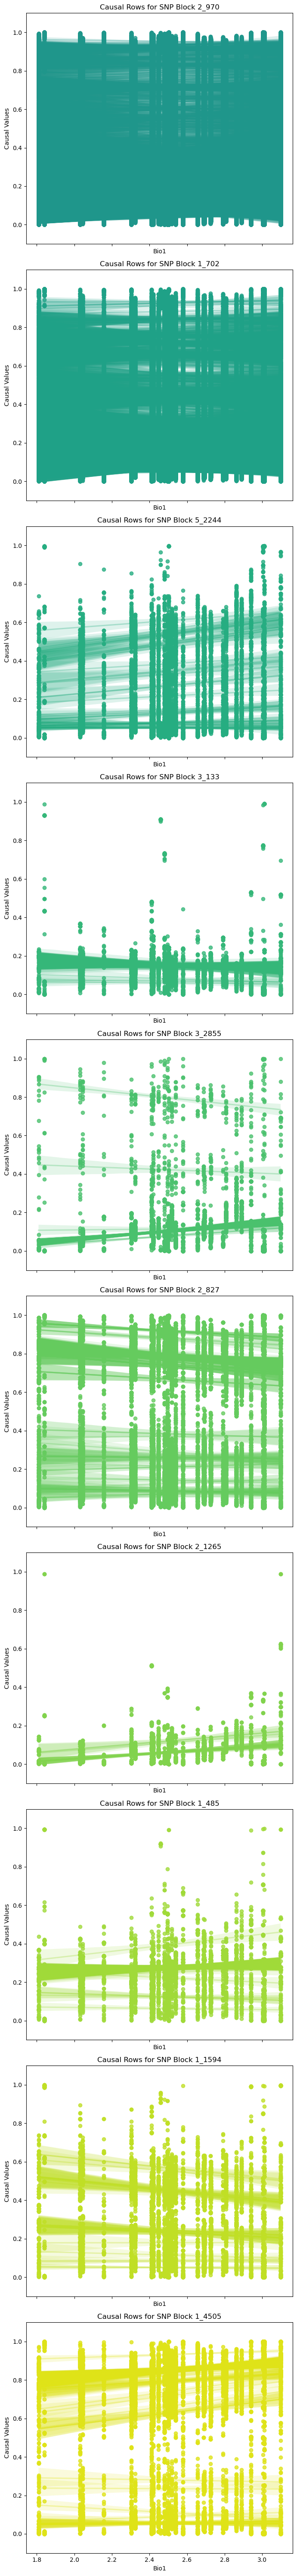

In [110]:
# Identify unique blocks from your data
unique_blocks = adaptive_unique_blocks

# Create subplots: one for each unique block
fig, axes = plt.subplots(nrows=len(unique_blocks), figsize=(7, 6 * len(unique_blocks)), sharex=True,sharey=True)

# If there's only one unique block, `axes` will not be an array, so we make it one
if len(unique_blocks) == 1:
    axes = [axes]

# Plot each row of causal as a line in the corresponding subplot
for i, block in enumerate(unique_blocks):
    # Filter the rows corresponding to the current block
    block_rows = causal_det[causal_det['block'] == block].index
    color = block_color_dict[block]
    
    for row in block_rows:
        # Perform linear regression between bio1 and the current row of causal values        
        # Plot the causal values for this row
        sns.regplot(x=bio1, y=causal_values[row], ax=axes[i], label=f'Row {row + 1}', color=color,
                    line_kws={"alpha": 0.3})  # scatter_kws={'s': 50}, 
        
        # Annotate the plot with the R-squared value
    
    # Set labels and title for each subplot
    axes[i].set_title(f'Causal Rows for SNP Block {block}')
    axes[i].set_xlabel('Bio1')
    axes[i].set_ylabel('Causal Values')
    axes[i].set_ylim(-0.1, 1.1)
    
# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
'2_1265'

In [ ]:
from scipy.stats import linregress


unique blocks from your data
unique_blocks = causal_det['block'].unique()

# Create subplots: one for each unique block
fig, axes = plt.subplots(nrows=len(unique_blocks), figsize=(5, 3 * len(unique_blocks)), sharex=True,sharey=True)

# If there's only one unique block, `axes` will not be an array, so we make it one
if len(unique_blocks) == 1:
    axes = [axes]

# Plot each row of causal as a line in the corresponding subplot
for i, block in enumerate(unique_blocks):
    # Filter the rows corresponding to the current block
    block_rows = causal_det[causal_det['block'] == block].index
    color = block_color_dict[block]
    
    for row in block_rows:
        # Plot the causal values for this row
        sns.lineplot(x=bio1, y=causal_values[row], ax=axes[i], label=f'Row {row + 1}', color=color, alpha=0.4, legend=False)

    
    # Set labels and title for each subplot
    axes[i].set_title(f'Causal Rows for SNP Block {block}')
    axes[i].set_xlabel('Bio1')
    axes[i].set_ylabel('Causal Values')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


In [33]:
block2 = causal_det[causal_det['chrom']==2]['maf05filter'].values

In [30]:
p0_average_seed_mix = pd.read_csv('../key_files/p0_average_seed_mix.csv')
snps_dict = pd.read_csv('../key_files/var_pos_grenenet.csv')
p0_average_seed_mix = pd.concat([p0_average_seed_mix,snps_dict ], axis=1)

In [35]:
p0_average_seed_mix[p0_average_seed_mix['id'].isin(block2)]

0          id       pos  chrom maf05filter  \
1181469  0.065530  2_11533904  11533904      2  2_11533904   
1181471  0.058988  2_11533937  11533937      2  2_11533937   
1181473  0.065530  2_11533991  11533991      2  2_11533991   
1181474  0.065530  2_11533994  11533994      2  2_11533994   
1181476  0.065530  2_11534015  11534015      2  2_11534015   
1181477  0.065530  2_11534022  11534022      2  2_11534022   
1181478  0.065530  2_11534023  11534023      2  2_11534023   
1181480  0.065530  2_11534048  11534048      2  2_11534048   
1181481  0.112015  2_11534063  11534063      2  2_11534063   
1181483  0.062538  2_11534094  11534094      2  2_11534094   
1181484  0.062538  2_11534099  11534099      2  2_11534099   
1181485  0.057749  2_11534102  11534102      2  2_11534102   
1181486  0.112015  2_11534143  11534143      2  2_11534143   
1181488  0.067175  2_11534165  11534165      2  2_11534165   
1181490  0.096814  2_11534244  11534244      2  2_11534244   
1181491  0.056145  2_11534263  11534263      2  2_11534263   

        total_alleles05filter  
1181469            2_11533904  
1181471            2_11533937  
1181473            2_11533991  
1181474            2_11533994  
1181476            2_11534015  
1181477            2_11534022  
1181478            2_11534023  
1181480            2_11534048  
1181481            2_11534063  
1181483            2_11534094  
1181484            2_11534099  
1181485            2_11534102  
1181486            2_11534143  
1181488            2_11534165  
1181490            2_11534244  
1181491            2_11534263

In [36]:
p0_average_seed_mix

0          id       pos  chrom maf05filter  \
0        0.037575       1_291       291      1         NaN   
1        0.264121       1_346       346      1       1_346   
2        0.010239       1_349       349      1         NaN   
3        0.020212       1_352       352      1         NaN   
4        0.067621       1_353       353      1       1_353   
...           ...         ...       ...    ...         ...   
3235475  0.012561  5_26975208  26975208      5         NaN   
3235476  0.016091  5_26975215  26975215      5         NaN   
3235477  0.004589  5_26975267  26975267      5         NaN   
3235478  0.410081  5_26975272  26975272      5  5_26975272   
3235479  0.197647  5_26975288  26975288      5  5_26975288   

        total_alleles05filter  
0                         NaN  
1                       1_346  
2                         NaN  
3                         NaN  
4                       1_353  
...                       ...  
3235475                   NaN  
3235476                   NaN  
3235477                   NaN  
3235478            5_26975272  
3235479            5_26975288  

[3235480 rows x 6 columns]

In [39]:
neutrals = p0_average_seed_mix[(p0_average_seed_mix['0'] > 0.058) & (p0_average_seed_mix['0'] < 0.059)]

In [135]:
len(neutrals)

50

In [66]:
neutrals = neutrals.sample(50)

In [ ]:
import subprocess

# Assuming `neutrals` is a DataFrame with rows you want to iterate over
# Example `neutrals` structure
# import pandas as pd
# neutrals = pd.DataFrame(...)

awk_conditions = []

for i in neutrals.index:
    start_idx = i + 2  # Adjusting the start index
    end_idx = i + 3  # Adjusting the end index
    awk_conditions.append(f"NR >= {start_idx} && NR <= {end_idx}")  # Convert integers to strings inside f-string


# Join the conditions with ' || ' to match the awk syntax
awk_filter = ' || '.join(awk_conditions)

# Construct the final awk command
awk_command = f"awk '{awk_filter}' ../baypass_terminal/merged_hapFIRE_allele_frequency_indexed.csv > af_neutral_if_2_1265.csv"

# Run the command using subprocess
subprocess.run(awk_command, shell=True, check=True)

In [74]:
neutrals['id'].values

array(['2_19030424', '1_16279410', '1_7645179', '4_5704255', '3_2061019',
       '3_18809820', '5_4466195', '3_18010115', '2_11016513', '4_4890387',
       '2_16483018', '1_17232601', '2_376392', '2_7372515', '2_19160964',
       '2_12876499', '1_8552207', '4_7851804', '1_27517761', '4_5100275',
       '4_11744841', '1_10839531', '3_22841375', '2_8758563',
       '3_22326837', '3_5578985', '5_7743349', '1_22688302', '2_17802541',
       '2_1627221', '4_7970206', '1_13280218', '3_7024804', '2_796039',
       '4_8937602', '2_6526948', '5_12945705', '5_15100075', '5_5787724',
       '3_17566381', '4_14158229', '1_28786681', '5_2094269',
       '3_12281443', '3_21774728', '3_3419638', '5_22802841', '2_2810486',
       '2_8271514', '3_12282821'], dtype=object)

In [140]:
neutral_freq = pd.read_csv('af_neutral_if_2_1265.csv',header=None)
usecols = pd.read_csv('../baypass_terminal/merged_hapFIRE_allele_frequency_indexed.csv',nrows =1).columns 
neutral_freq.columns = usecols

In [141]:
#neutral_freq = neutral_freq[first_gen]
neutral_freq = neutral_freq[neutral_freq['0'].isin(neutrals['id'].values)][first_gen]

In [149]:
neutral_freq - 

0   1   2   3   4   5   6   7   8   9  ...  9_1_11  9_1_12  9_1_2  9_1_3  \
0  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
2  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
8  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
10 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
12 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
14 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
16 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
18 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
20 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
22 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
24 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
26 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
28 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
32 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
34 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
36 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
38 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
40 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
42 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
44 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
46 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
48 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
50 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
52 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
54 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
56 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
58 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
60 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
62 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
64 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
66 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
68 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
70 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
72 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
74 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
76 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
78 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
80 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
82 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
84 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
86 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
88 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
90 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
92 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
94 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN     NaN    NaN    NaN   
96 NaN NaN NaN NaN NaN NaN NaN NaN N

0     0.058435
1     0.058830
2     0.058894
3     0.058738
4     0.058815
5     0.058824
6     0.058535
7     0.058884
8     0.058734
9     0.058635
10    0.058664
11    0.058106
12    0.058534
13    0.058113
14    0.058820
15    0.058744
16    0.058617
17    0.058155
18    0.058722
19    0.058210
20    0.058750
21    0.058203
22    0.058903
23    0.058133
24    0.058753
25    0.058114
26    0.058803
27    0.058467
28    0.058491
29    0.058704
30    0.058499
31    0.058871
32    0.058625
33    0.058961
34    0.058968
35    0.058044
36    0.058569
37    0.058078
38    0.058658
39    0.058856
40    0.058059
41    0.058942
42    0.058020
43    0.058198
44    0.058961
45    0.058863
46    0.058116
47    0.058508
48    0.058879
49    0.058198
Name: 0, dtype: float64

In [142]:
neutral_freq - 

1_1_1     1_1_2     1_1_3     1_1_4     1_1_5     1_1_6     1_1_7  \
0   0.038051  0.096397  0.084763  0.042942  0.097763  0.068146  0.036804   
2   0.082206  0.031089  0.029637  0.084086  0.102528  0.045415  0.050729   
4   0.060314  0.026194  0.049763  0.056249  0.049886  0.045320  0.042928   
6   0.032655  0.062203  0.043531  0.050374  0.045988  0.040957  0.100547   
8   0.098019  0.066753  0.087907  0.068246  0.084744  0.076992  0.074137   
10  0.043525  0.081214  0.093113  0.068681  0.047140  0.058061  0.042231   
12  0.049914  0.071983  0.034270  0.086096  0.069854  0.065661  0.064427   
14  0.056029  0.045885  0.090167  0.079420  0.060596  0.063862  0.040896   
16  0.119954  0.070582  0.023954  0.075273  0.088149  0.089177  0.071361   
18  0.061054  0.054889  0.027402  0.054106  0.070125  0.076391  0.065727   
20  0.058371  0.048880  0.061677  0.071065  0.062844  0.065787  0.059492   
22  0.073595  0.063493  0.090159  0.047951  0.118393  0.066565  0.056568   
24  0.042393  0.077598  0.044292  0.042679  0.105580  0.044972  0.073436   
26  0.056007  0.067584  0.045512  0.050851  0.099209  0.056475  0.104705   
28  0.084694  0.037542  0.052430  0.082934  0.098860  0.069192  0.061971   
30  0.037991  0.058886  0.050500  0.054159  0.077489  0.047160  0.050664   
32  0.084138  0.092462  0.073041  0.069303  0.050813  0.063076  0.083166   
34  0.036076  0.034882  0.072773  0.035355  0.072467  0.081105  0.043987   
36  0.046735  0.072217  0.074043  0.047458  0.052735  0.072235  0.061485   
38  0.034137  0.021134  0.052922  0.028564  0.027960  0.018213  0.022664   
40  0.035954  0.046865  0.048598  0.044144  0.067580  0.076328  0.046841   
42  0.053640  0.046546  0.051519  0.047422  0.087066  0.056628  0.037584   
44  0.059036  0.007198  0.010062  0.014104  0.003513  0.018917  0.017113   
46  0.030006  0.020805  0.026458  0.027394  0.033029  0.044703  0.029740   
48  0.067406  0.030066  0.017428  0.021283  0.038260  0.025003  0.041302   
50  0.042752  0.036356  0.037136  0.088402  0.038995  0.023536  0.037106   
52  0.052818  0.011093  0.017192  0.026214  0.023630  0.014186  0.022281   
54  0.053770  0.029490  0.023115  0.045537  0.047881  0.073993  0.056450   
56  0.053770  0.029490  0.023115  0.045537  0.047881  0.073993  0.056450   
58  0.029024  0.038977  0.019643  0.041699  0.021448  0.030613  0.028117   
60  0.027769  0.052094  0.037867  0.039485  0.053189  0.089196  0.049694   
62  0.110539  0.056249  0.107333  0.067486  0.059940  0.053371  0.075519   
64  0.041891  0.041061  0.057158  0.045674  0.049904  0.072975  0.053042   
66  0.071848  0.060897  0.056266  0.061091  0.042455  0.077097  0.040794   
68  0.047347  0.060787  0.065669  0.078224  0.047585  0.049539  0.032732   
70  0.065625  0.029967  0.021945  0.019047  0.007660  0.057374  0.045054   
72  0.088607  0.042041  0.073170  0.064866  0.043145  0.048049  0.028217   
74  0.046262  0.049331  0.062161  0.041954  0.053096  0.076010  0.061168   
76  0.063672  0.055301  0.069249  0.044465  0.107783  0.052149  0.114207   
78  0.049168  0.083663  0.070037  0.057584  0.069986  0.052016  0.059004   
80  0.046350  0.045391  0.061335  0.069457  0.085950  0.106385  0.069745   
82  0.070921  0.081230  0.063604  0.053044  0.051751  0.074618  0.056252   
84  0.053988  0.037278  0.032272  0.018753  0.039325  0.059630  0.030986   
86  0.032233  0.045847  0.049892  0.056723  0.048061  0.053794  0.057873   
88  0.090350  0.098563  0.056957  0.076969  0.127841  0.113097  0.062236   
90  0.054214  0.038070  0.041671  0.066645  0.037642  0.056917  0.030760   
92  0.069788  0.049699  0.041326  0.052045  0.052740  0.072289  0.042436   
94  0.045688  0.029899  0.012990  0.026774  0.028789  0.033678  0.025468   
96  0.086111  0.062663  0.121089  0.087271  0.058292  0.062008  0.077338   
98  0.028198  0.063445  0.046506  0.053872  0.084233  0.061106  0.095178   

       1_1_8     1_1_9    1_1_10  ...    60_1_3    60_1_4    60_1_5    60_1_6  \
0   0.062922  0.094118  0.050714  ...  0.028345  

In [86]:
causal_det

pos  chrom maf05filter total_alleles05filter   block
0    11533904      2  2_11533904            2_11533904  2_1265
1    11533937      2  2_11533937            2_11533937  2_1265
2    11533991      2  2_11533991            2_11533991  2_1265
3    11533994      2  2_11533994            2_11533994  2_1265
4    11534015      2  2_11534015            2_11534015  2_1265
..        ...    ...         ...                   ...     ...
236   7268624      4   4_7268624             4_7268624   4_801
237   7268851      4   4_7268851             4_7268851   4_801
238   7269036      4   4_7269036             4_7269036   4_801
239   7269161      4   4_7269161             4_7269161   4_801
240   7269288      4   4_7269288             4_7269288   4_801

[241 rows x 5 columns]

In [88]:
mask = causal_det['chrom']==2

In [90]:
mask

0       True
1       True
2       True
3       True
4       True
       ...  
236    False
237    False
238    False
239    False
240    False
Name: chrom, Length: 241, dtype: bool

In [92]:
mask

0       True
1       True
2       True
3       True
4       True
       ...  
236    False
237    False
238    False
239    False
240    False
Name: chrom, Length: 241, dtype: bool

In [98]:
block2 = causal_values.T[mask]

In [99]:
block2

1_1_1     1_1_2     1_1_3     1_1_4     1_1_5     1_1_6     1_1_7  \
0   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
1   0.043572  0.038390  0.028944  0.069723  0.031766  0.047597  0.042314   
2   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
3   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
4   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
5   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
6   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
7   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
8   0.071188  0.066588  0.067505  0.112902  0.056796  0.078192  0.073303   
9   0.039653  0.039781  0.029791  0.070048  0.032004  0.047955  0.043310   
10  0.039653  0.039781  0.029791  0.070048  0.032004  0.047955  0.043310   
11  0.038917  0.039273  0.029185  0.062116  0.029728  0.044116  0.037258   
12  0.071188  0.066588  0.067505  0.112902  0.056796  0.078192  0.073303   
13  0.044981  0.040624  0.030693  0.074458  0.033220  0.050978  0.043990   
14  0.063673  0.063617  0.056576  0.098165  0.051257  0.068987  0.064923   
15  0.038556  0.038522  0.028702  0.061011  0.029158  0.043172  0.036649   

       1_1_8     1_1_9    1_1_10  ...    60_1_3    60_1_4    60_1_5    60_1_6  \
0   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
1   0.064441  0.067077  0.070456  ...  0.008829  0.063839  0.077403  0.133840   
2   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
3   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
4   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
5   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
6   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
7   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
8   0.088695  0.093396  0.100064  ...  0.170426  0.161930  0.107629  0.370106   
9   0.064247  0.057373  0.065437  ...  0.009692  0.115590  0.077611  0.204634   
10  0.064247  0.057373  0.065437  ...  0.009692  0.115590  0.077611  0.204634   
11  0.052664  0.053879  0.062191  ...  0.009127  0.113239  0.077146  0.204634   
12  0.088695  0.093396  0.100064  ...  0.170426  0.161930  0.107629  0.370106   
13  0.067891  0.070703  0.073735  ...  0.009804  0.118465  0.077741  0.204827   
14  0.070732  0.073953  0.076277  ...  0.168864  0.112632  0.106324  0.367175   
15  0.051105  0.052861  0.061025  ...  0.009024  0.111023  0.076993  0.202181   

      60_1_7    60_1_8    60_1_9   60_1_10   60_1_11   60_1_12  
0   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
1   0.004321  0.072120  0.345257  0.071445  0.243393  0.051130  
2   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
3   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
4   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
5   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
6   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
7   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
8   0.191743  0.087310  0.369516  0.139029  0.349037  0.091622  
9   0.036006  0.073134  0.348415  0.071968  0.308549  0.047415  
10  0.036006  0.073134  0.348415  0.071968  0.308549  0.047415  
11  0.036006  0.072778  0.347618  0.071321  0.308237  0.046679  
12  0.191743  0.087310  0.369516  0.139029  0.349037  0.091622  
13  0.036006  0.073235  0.350618  0.072527  0.308549  0.088986  
14  0.190651  0.085477  0.362694  0.136659  0.345803  0.047057  
15  0.035209  0.072345  0.345974  0.070964  0.305849  0.045014  

[16 rows x 326 columns]

In [136]:
neutral_freq

1_1_1     1_1_2     1_1_3     1_1_4     1_1_5     1_1_6     1_1_7  \
0   0.038051  0.096397  0.084763  0.042942  0.097763  0.068146  0.036804   
1   0.038051  0.096397  0.084763  0.042942  0.097763  0.068146  0.036804   
2   0.082206  0.031089  0.029637  0.084086  0.102528  0.045415  0.050729   
3   0.041444  0.065065  0.040518  0.031237  0.026752  0.056676  0.039884   
4   0.060314  0.026194  0.049763  0.056249  0.049886  0.045320  0.042928   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.002951  0.003578  0.003298  0.004031  0.005492  0.003058  0.003348   
96  0.086111  0.062663  0.121089  0.087271  0.058292  0.062008  0.077338   
97  0.468896  0.447376  0.430263  0.484774  0.528785  0.434957  0.440900   
98  0.028198  0.063445  0.046506  0.053872  0.084233  0.061106  0.095178   
99  0.047737  0.051296  0.029711  0.037919  0.040532  0.030578  0.027590   

       1_1_8     1_1_9    1_1_10  ...    60_1_3    60_1_4    60_1_5    60_1_6  \
0   0.062922  0.094118  0.050714  ...  0.028345  0.003527  0.033852  0.002540   
1   0.062922  0.094118  0.050714  ...  0.028345  0.003527  0.033852  0.002540   
2   0.063796  0.053246  0.063512  ...  0.152640  0.122180  0.063297  0.006714   
3   0.028677  0.035905  0.038288  ...  0.022915  0.001800  0.002586  0.001291   
4   0.026898  0.049979  0.047079  ...  0.011829  0.004779  0.122654  0.004213   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  0.003245  0.014501  0.002896  ...  0.001486  0.040989  0.000886  0.000536   
96  0.093237  0.085610  0.077546  ...  0.050725  0.011666  0.082853  0.019403   
97  0.466468  0.400619  0.464451  ...  0.487303  0.213756  0.379720  0.721505   
98  0.044648  0.033200  0.108226  ...  0.210345  0.004388  0.004286  0.003134   
99  0.043445  0.039469  0.035912  ...  0.066911  0.060119  0.002471  0.014398   

      60_1_7    60_1_8    60_1_9   60_1_10   60_1_11   60_1_12  
0   0.032017  0.036578  0.129359  0.023018  0.042521  0.008063  
1   0.032017  0.036578  0.129359  0.023018  0.042521  0.008063  
2   0.015035  0.009353  0.008421  0.079726  0.002812  0.008665  
3   0.028097  0.027981  0.004632  0.032607  0.001524  0.071955  
4   0.050071  0.113020  0.007319  0.062977  0.003536  0.008294  
..       ...       ...       ...       ...       ...       ...  
95  0.001180  0.001434  0.002026  0.000995  0.000343  0.001499  
96  0.006186  0.043943  0.183193  0.014999  0.293891  0.069153  
97  0.256573  0.320934  0.652045  0.588443  0.637173  0.414623  
98  0.011945  0.018519  0.007464  0.118942  0.004538  0.128441  
99  0.004332  0.007148  0.042939  0.004208  0.005143  0.044220  

[100 rows x 326 columns]

In [102]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming bio1, block2, and neutral_freq are your DataFrames
# bio1 contains environmental temperature values with sample names as index
# block2 and neutral_freq contain allele frequencies with sample names as columns

# First, melt the block2 and neutral_freq dataframes to match bio1
block2_melted = block2.melt(var_name='sample', value_name='allele_frequency')
neutral_freq_melted = neutral_freq.melt(var_name='sample', value_name='allele_frequency')

# Add a column to distinguish the source
block2_melted['source'] = 'block2'
neutral_freq_melted['source'] = 'neutral'

# Combine both melted datasets
combined_df = pd.concat([block2_melted, neutral_freq_melted])

# Merge combined_df with bio1 to get environmental temperature for each sample
combined_df = combined_df.merge(bio1, left_on='sample', right_index=True)

In [103]:
combined_df

sample  allele_frequency   source       bio1
0        1_1_1          0.044251   block2  10.209418
1        1_1_1          0.043572   block2  10.209418
2        1_1_1          0.044251   block2  10.209418
3        1_1_1          0.044251   block2  10.209418
4        1_1_1          0.044251   block2  10.209418
...        ...               ...      ...        ...
16295  60_1_12          0.048779  neutral  18.908464
16296  60_1_12          0.012297  neutral  18.908464
16297  60_1_12          0.026355  neutral  18.908464
16298  60_1_12          0.069153  neutral  18.908464
16299  60_1_12          0.128441  neutral  18.908464

[21516 rows x 4 columns]

In [109]:
block2

1_1_1     1_1_2     1_1_3     1_1_4     1_1_5     1_1_6     1_1_7  \
0   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
1   0.043572  0.038390  0.028944  0.069723  0.031766  0.047597  0.042314   
2   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
3   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
4   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
5   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
6   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
7   0.044251  0.039594  0.029825  0.073591  0.032463  0.049082  0.043163   
8   0.071188  0.066588  0.067505  0.112902  0.056796  0.078192  0.073303   
9   0.039653  0.039781  0.029791  0.070048  0.032004  0.047955  0.043310   
10  0.039653  0.039781  0.029791  0.070048  0.032004  0.047955  0.043310   
11  0.038917  0.039273  0.029185  0.062116  0.029728  0.044116  0.037258   
12  0.071188  0.066588  0.067505  0.112902  0.056796  0.078192  0.073303   
13  0.044981  0.040624  0.030693  0.074458  0.033220  0.050978  0.043990   
14  0.063673  0.063617  0.056576  0.098165  0.051257  0.068987  0.064923   
15  0.038556  0.038522  0.028702  0.061011  0.029158  0.043172  0.036649   

       1_1_8     1_1_9    1_1_10  ...    60_1_3    60_1_4    60_1_5    60_1_6  \
0   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
1   0.064441  0.067077  0.070456  ...  0.008829  0.063839  0.077403  0.133840   
2   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
3   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
4   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
5   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
6   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
7   0.066333  0.069596  0.071941  ...  0.009054  0.117680  0.077498  0.189218   
8   0.088695  0.093396  0.100064  ...  0.170426  0.161930  0.107629  0.370106   
9   0.064247  0.057373  0.065437  ...  0.009692  0.115590  0.077611  0.204634   
10  0.064247  0.057373  0.065437  ...  0.009692  0.115590  0.077611  0.204634   
11  0.052664  0.053879  0.062191  ...  0.009127  0.113239  0.077146  0.204634   
12  0.088695  0.093396  0.100064  ...  0.170426  0.161930  0.107629  0.370106   
13  0.067891  0.070703  0.073735  ...  0.009804  0.118465  0.077741  0.204827   
14  0.070732  0.073953  0.076277  ...  0.168864  0.112632  0.106324  0.367175   
15  0.051105  0.052861  0.061025  ...  0.009024  0.111023  0.076993  0.202181   

      60_1_7    60_1_8    60_1_9   60_1_10   60_1_11   60_1_12  
0   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
1   0.004321  0.072120  0.345257  0.071445  0.243393  0.051130  
2   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
3   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
4   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
5   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
6   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
7   0.035397  0.072443  0.349814  0.071965  0.307933  0.088219  
8   0.191743  0.087310  0.369516  0.139029  0.349037  0.091622  
9   0.036006  0.073134  0.348415  0.071968  0.308549  0.047415  
10  0.036006  0.073134  0.348415  0.071968  0.308549  0.047415  
11  0.036006  0.072778  0.347618  0.071321  0.308237  0.046679  
12  0.191743  0.087310  0.369516  0.139029  0.349037  0.091622  
13  0.036006  0.073235  0.350618  0.072527  0.308549  0.088986  
14  0.190651  0.085477  0.362694  0.136659  0.345803  0.047057  
15  0.035209  0.072345  0.345974  0.070964  0.305849  0.045014  

[16 rows x 326 columns]

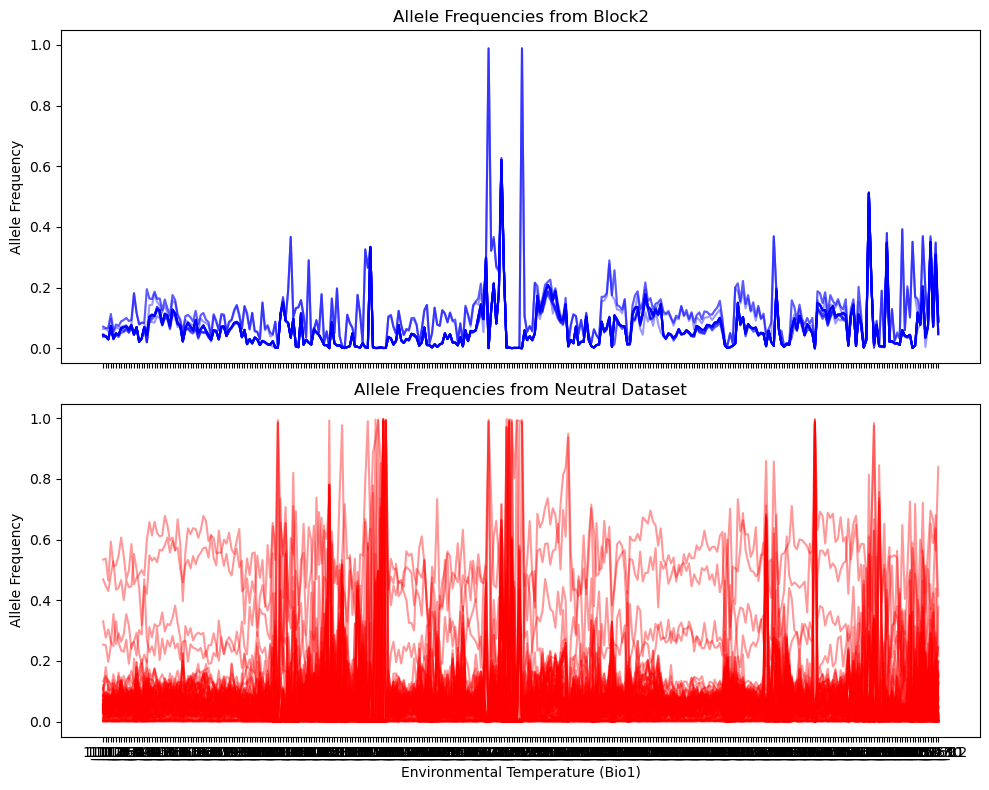

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming bio1, block2, and neutral_freq are your DataFrames
# bio1 contains environmental temperature values with sample names as index
# block2 and neutral_freq contain allele frequencies with sample names as columns

# Create subplots: one row for block2 and one for neutral_freq
fig, axes = plt.subplots(nrows=2, figsize=(10, 8), sharex=True, sharey=True)

# If there's only one axis, ensure it's treated as a list
if len(axes) == 1:
    axes = [axes]

# Plot each row of block2 as a line in the first subplot
for row in range(block2.shape[0]):
    color = 'blue'
    sns.lineplot(x=bio1.index, y=block2.iloc[row], ax=axes[0], label=f'Block2 Row {row + 1}', color=color, alpha=0.4, legend=False)

# Set labels and title for the block2 subplot
axes[0].set_title('Allele Frequencies from Block2')
axes[0].set_ylabel('Allele Frequency')

# Plot each row of neutral_freq as a line in the second subplot
for row in range(neutral_freq.shape[0]):
    color = 'red'
    sns.lineplot(x=bio1.index, y=neutral_freq.iloc[row], ax=axes[1], label=f'Neutral Row {row + 1}', color=color, alpha=0.4, legend=False)

# Set labels and title for the neutral_freq subplot
axes[1].set_title('Allele Frequencies from Neutral Dataset')
axes[1].set_xlabel('Environmental Temperature (Bio1)')
axes[1].set_ylabel('Allele Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming bio1, block2, and neutral_freq are your DataFrames
# bio1 contains environmental temperature values with sample names as index
# block2 and neutral_freq contain allele frequencies with sample names as columns

# Transpose the block2 and neutral_freq so that sample names match bio1 index
block2_T = block2.T
neutral_freq_T = neutral_freq.T

# Create a combined DataFrame with bio1 values and mean allele frequencies for block2 and neutral_freq
block2_T['bio1'] = bio1.values
neutral_freq_T['bio1'] = bio1.values

In [123]:
neutral_freq_T.iloc[

0         1         2         3         4         5         6  \
1_1_1    0.038051  0.038051  0.082206  0.041444  0.060314  0.014755  0.032655   
1_1_2    0.096397  0.096397  0.031089  0.065065  0.026194  0.045788  0.062203   
1_1_3    0.084763  0.084763  0.029637  0.040518  0.049763  0.021855  0.043531   
1_1_4    0.042942  0.042942  0.084086  0.031237  0.056249  0.021111  0.050374   
1_1_5    0.097763  0.097763  0.102528  0.026752  0.049886  0.038304  0.045988   
...           ...       ...       ...       ...       ...       ...       ...   
60_1_8   0.036578  0.036578  0.009353  0.027981  0.113020  0.014176  0.134037   
60_1_9   0.129359  0.129359  0.008421  0.004632  0.007319  0.004907  0.452658   
60_1_10  0.023018  0.023018  0.079726  0.032607  0.062977  0.002783  0.006596   
60_1_11  0.042521  0.042521  0.002812  0.001524  0.003536  0.001166  0.229013   
60_1_12  0.008063  0.008063  0.008665  0.071955  0.008294  0.003058  0.009726   

                7         8         9  ...        91        92        93  \
1_1_1    0.004566  0.098019  0.000918  ...  0.054214  0.069788  0.070106   
1_1_2    0.005890  0.066753  0.000685  ...  0.038070  0.049699  0.052835   
1_1_3    0.005820  0.087907  0.000966  ...  0.041671  0.041326  0.041697   
1_1_4    0.004375  0.068246  0.000846  ...  0.066645  0.052045  0.069131   
1_1_5    0.007030  0.084744  0.000614  ...  0.037642  0.052740  0.055101   
...           ...       ...       ...  ...       ...       ...       ...   
60_1_8   0.002182  0.066623  0.000798  ...  0.037046  0.018759  0.046770   
60_1_9   0.001284  0.009185  0.000841  ...  0.097763  0.007943  0.052909   
60_1_10  0.001274  0.081372  0.000491  ...  0.110546  0.190116  0.249197   
60_1_11  0.000695  0.006843  0.000160  ...  0.076854  0.208451  0.278001   
60_1_12  0.002607  0.090778  0.000123  ...  0.048779  0.012297  0.012618   

               94        95        96        97        98        99       bio1  
1_1_1    0.045688  0.002951  0.086111  0.468896  0.028198  0.047737  10.209418  
1_1_2    0.029899  0.003578  0.062663  0.447376  0.063445  0.051296  10.209418  
1_1_3    0.012990  0.003298  0.121089  0.430263  0.046506  0.029711  10.209418  
1_1_4    0.026774  0.004031  0.087271  0.484774  0.053872  0.037919  10.209418  
1_1_5    0.028789  0.005492  0.058292  0.528785  0.084233  0.040532  10.209418  
...           ...       ...       ...       ...       ...       ...        ...  
60_1_8   0.003693  0.001434  0.043943  0.320934  0.018519  0.007148  18.908464  
60_1_9   0.006174  0.002026  0.183193  0.652045  0.007464  0.042939  18.908464  
60_1_10  0.190397  0.000995  0.014999  0.588443  0.118942  0.004208  18.908464  
60_1_11  0.030118  0.000343  0.293891  0.637173  0.004538  0.005143  18.908464  
60_1_12  0.026355  0.001499  0.069153  0.414623  0.128441  0.044220  18.908464  

[326 rows x 101 columns]

/tmp/ipykernel_4074150/1906023458.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='bio1', y=block2_T.iloc[:, :-1].mean(axis=1),
/tmp/ipykernel_4074150/1906023458.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='bio1', y=neutral_freq_T.iloc[:, :-1].mean(axis=1),


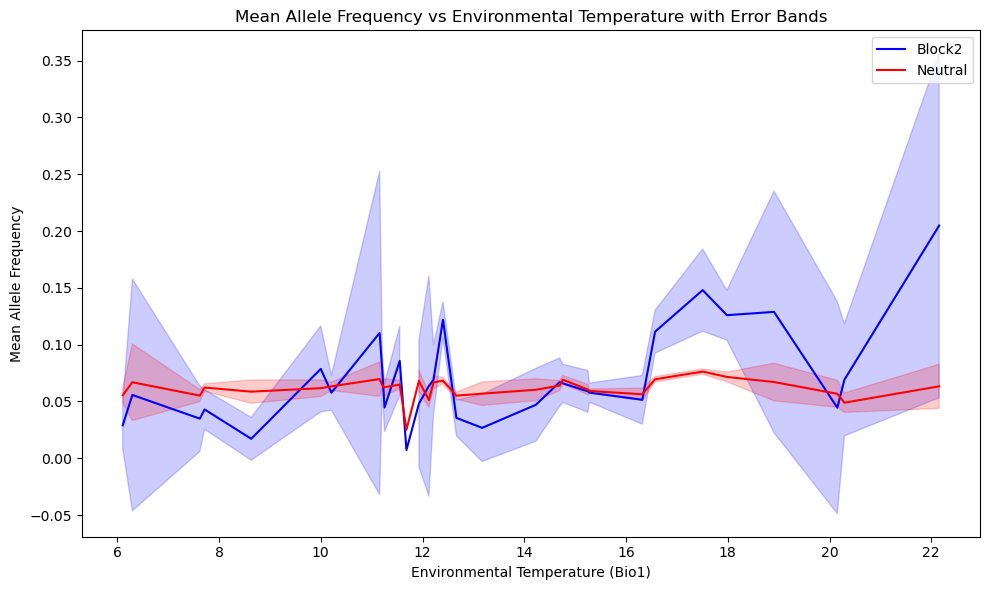

In [120]:


# Plotting
plt.figure(figsize=(10, 6))

# Plot mean allele frequency with standard deviation (or confidence interval) for block2
sns.lineplot(x='bio1', y=block2_T.iloc[:, :-1].mean(axis=1), 
             ci='sd', data=block2_T, label='Block2', color='blue')

# Plot mean allele frequency with standard deviation (or confidence interval) for neutral_freq
sns.lineplot(x='bio1', y=neutral_freq_T.iloc[:, :-1].mean(axis=1), 
             ci='sd', data=neutral_freq_T, label='Neutral', color='red')

# Customize the plot
plt.title('Mean Allele Frequency vs Environmental Temperature with Error Bands')
plt.xlabel('Environmental Temperature (Bio1)')
plt.ylabel('Mean Allele Frequency')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_4074150/3882194625.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='bio1', y=block2_T.iloc[:, :-1].mean(axis=1),
/tmp/ipykernel_4074150/3882194625.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='bio1', y=neutral_freq_T.iloc[:, :-1].mean(axis=1),


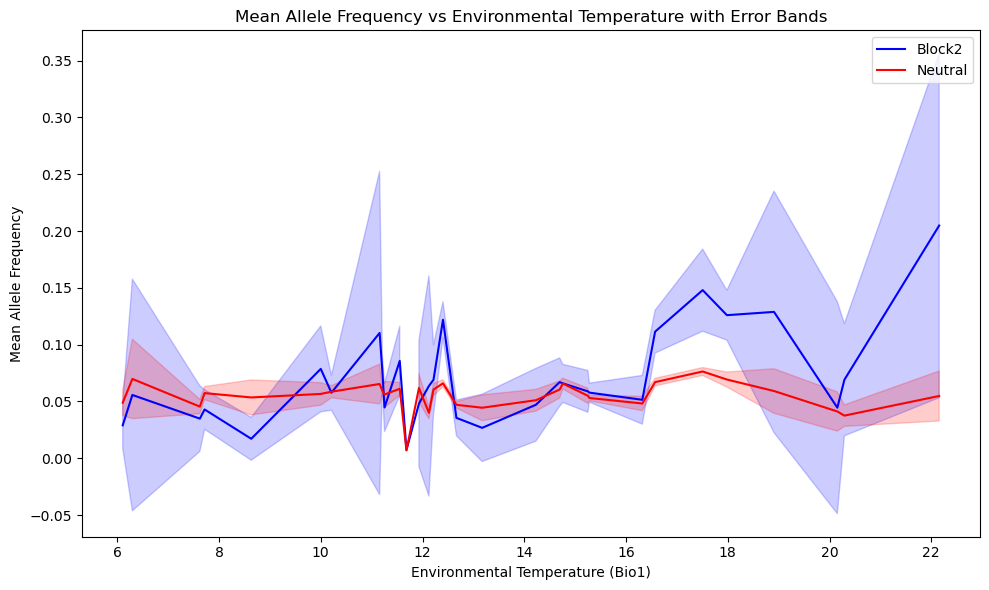

In [111]:
bbb


/tmp/ipykernel_4074150/3983651770.py:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x=block2_T['bio1'], y=block2_T.iloc[:, :-1].mean(axis=1),


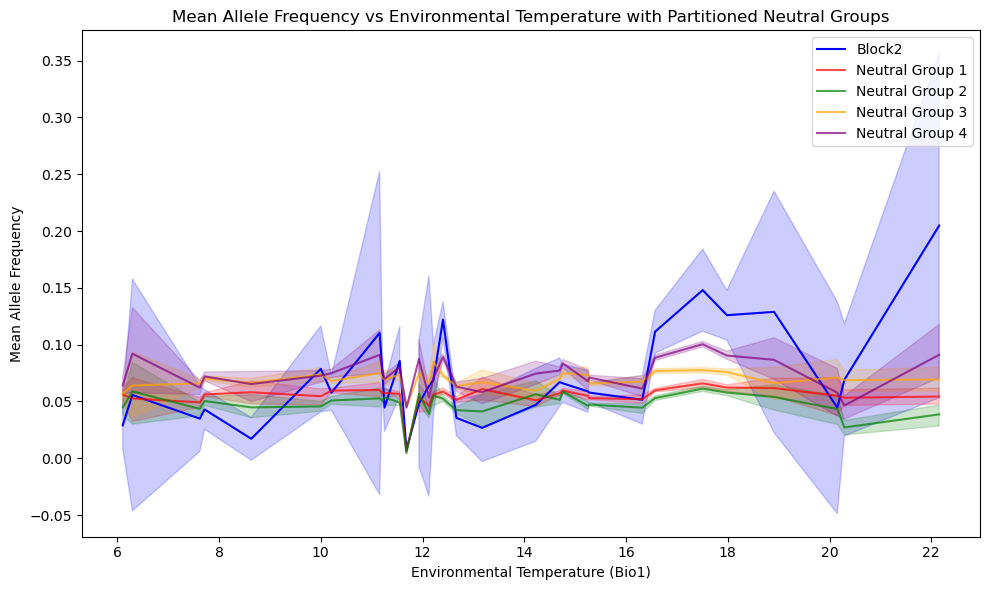

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming bio1, block2, and neutral_freq are your DataFrames
# bio1 contains environmental temperature values with sample names as index
# block2 and neutral_freq contain allele frequencies with sample names as columns

# Transpose the block2 and neutral_freq so that sample names match bio1 index
block2_T = block2.T
neutral_freq_T = neutral_freq.T

# Add bio1 to the transposed dataframes
block2_T['bio1'] = bio1.values
neutral_freq_T['bio1'] = bio1.values

# Partition the neutral_freq_T DataFrame into 4 groups
n_groups = 4
group_size = neutral_freq_T.shape[1] // n_groups
grouped_neutral_freq_means = []
grouped_neutral_freq_stds = []

for i in range(n_groups):
    start_col = i * group_size
    end_col = (i + 1) * group_size
    group_mean = neutral_freq_T.iloc[:, start_col:end_col].mean(axis=1)
    group_std = neutral_freq_T.iloc[:, start_col:end_col].std(axis=1)
    grouped_neutral_freq_means.append(group_mean)
    grouped_neutral_freq_stds.append(group_std)

# Convert grouped means and stds to DataFrames for easy plotting
grouped_neutral_freq_means = pd.DataFrame(grouped_neutral_freq_means).T
grouped_neutral_freq_stds = pd.DataFrame(grouped_neutral_freq_stds).T

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean allele frequency with standard deviation (or confidence interval) for block2
sns.lineplot(x=block2_T['bio1'], y=block2_T.iloc[:, :-1].mean(axis=1), 
             ci='sd', label='Block2', color='blue')

# Plot each partitioned group of neutral_freq as a separate line with error bands
colors = ['red', 'green', 'orange', 'purple']
for group_idx in range(n_groups):
    sns.lineplot(x=neutral_freq_T['bio1'], 
                 y=grouped_neutral_freq_means.iloc[:, group_idx], 
                 label=f'Neutral Group {group_idx + 1}', 
                 color=colors[group_idx],
                 alpha=0.7)

# Customize the plot
plt.title('Mean Allele Frequency vs Environmental Temperature with Partitioned Neutral Groups')
plt.xlabel('Environmental Temperature (Bio1)')
plt.ylabel('Mean Allele Frequency')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


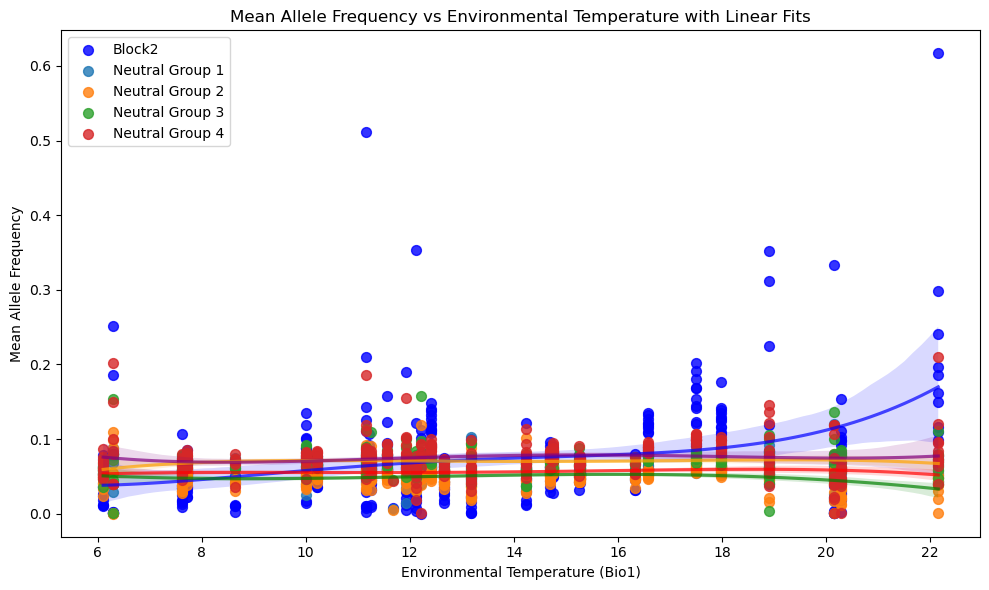

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming bio1, block2, and neutral_freq are your DataFrames
# bio1 contains environmental temperature values with sample names as index
# block2 and neutral_freq contain allele frequencies with sample names as columns

# Transpose the block2 and neutral_freq so that sample names match bio1 index
block2_T = block2.T
neutral_freq_T = neutral_freq.T

# Add bio1 to the transposed dataframes
block2_T['bio1'] = bio1.values
neutral_freq_T['bio1'] = bio1.values

# Partition the neutral_freq_T DataFrame into 4 groups
n_groups = 4
group_size = neutral_freq_T.shape[1] // n_groups
grouped_neutral_freq_means = []
grouped_neutral_freq_stds = []

for i in range(n_groups):
    start_col = i * group_size
    end_col = (i + 1) * group_size
    group_mean = neutral_freq_T.iloc[:, start_col:end_col].mean(axis=1)
    group_std = neutral_freq_T.iloc[:, start_col:end_col].std(axis=1)
    grouped_neutral_freq_means.append(group_mean)
    grouped_neutral_freq_stds.append(group_std)

# Convert grouped means and stds to DataFrames for easy plotting
grouped_neutral_freq_means = pd.DataFrame(grouped_neutral_freq_means).T
grouped_neutral_freq_stds = pd.DataFrame(grouped_neutral_freq_stds).T

# Plotting
plt.figure(figsize=(10, 6))

# Scatterplot with linear regression fit for block2
sns.regplot(x=block2_T['bio1'], y=block2_T.iloc[:, :-1].mean(axis=1),  order=4,
            label='Block2', color='blue', scatter_kws={'s': 50}, line_kws={"color": "blue", "alpha": 0.7}, )

# Scatterplot with linear regression fits for each partitioned group of neutral_freq
colors = ['red', 'green', 'orange', 'purple']
for group_idx in range(n_groups):
    sns.regplot(x=neutral_freq_T['bio1'], order=4,
                y=grouped_neutral_freq_means.iloc[:, group_idx], 
                label=f'Neutral Group {group_idx + 1}', 
                scatter_kws={'s': 50}, line_kws={"color": colors[group_idx], "alpha": 0.7})

# Customize the plot
plt.title('Mean Allele Frequency vs Environmental Temperature with Linear Fits')
plt.xlabel('Environmental Temperature (Bio1)')
plt.ylabel('Mean Allele Frequency')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_4074150/4275648006.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='bio1', y=block2_T.iloc[:, :-1].mean(axis=1),


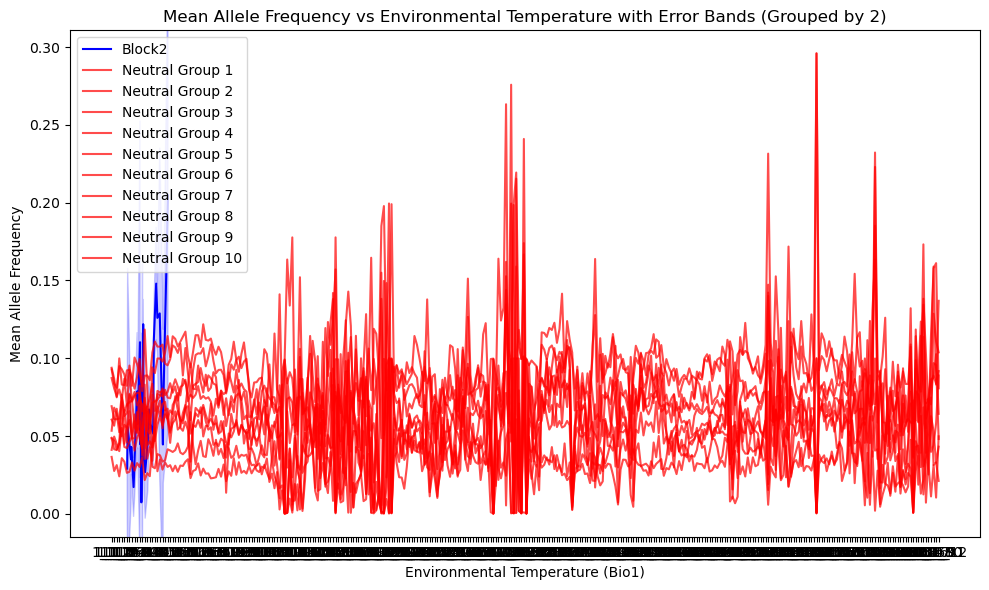

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming bio1, block2, and neutral_freq are your DataFrames
# bio1 contains environmental temperature values with sample names as index
# block2 and neutral_freq contain allele frequencies with sample names as columns

# Transpose the dataframes so sample names match bio1 index
block2_T = block2.T
neutral_freq_T = neutral_freq.T

# Add bio1 to the transposed dataframes
block2_T['bio1'] = bio1.values
neutral_freq_T['bio1'] = bio1.values

# Group neutral_freq in groups of 2 rows
group_size = 10
grouped_neutral_freq_means = []
grouped_neutral_freq_stds = []
for i in range(0, neutral_freq_T.shape[1] - 1, group_size):
    # Take two rows at a time and compute mean and standard deviation
    group_mean = neutral_freq_T.iloc[:, i:i + group_size].mean(axis=1)
    group_std = neutral_freq_T.iloc[:, i:i + group_size].std(axis=1)
    grouped_neutral_freq_means.append(group_mean)
    grouped_neutral_freq_stds.append(group_std)

# Convert grouped means and stds to DataFrames for easy plotting
grouped_neutral_freq_means = pd.DataFrame(grouped_neutral_freq_means).T
grouped_neutral_freq_stds = pd.DataFrame(grouped_neutral_freq_stds).T

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean allele frequency with standard deviation for block2
sns.lineplot(x='bio1', y=block2_T.iloc[:, :-1].mean(axis=1), 
             ci='sd', data=block2_T, label='Block2', color='blue')

# Plot each group of neutral_freq as a separate line with error bars
for group_idx in range(grouped_neutral_freq_means.shape[1]):
    sns.lineplot(x=bio1.index, y=grouped_neutral_freq_means.iloc[:, group_idx],
                 label=f'Neutral Group {group_idx + 1}', color='red', alpha=0.7)

# Customize the plot
plt.title('Mean Allele Frequency vs Environmental Temperature with Error Bands (Grouped by 2)')
plt.xlabel('Environmental Temperature (Bio1)')
plt.ylabel('Mean Allele Frequency')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
0.058988

In [ ]:
p0_average_seed_mix = pd.read_csv('../key_files/p0_average_seed_mix.csv')
snps_dict = pd.read_csv('../key_files/var_pos_grenenet.csv')
p0_average_seed_mix = pd.concat([p0_average_seed_mix,snps_dict ], axis=1)
initial_freq = p0_average_seed_mix[p0_average_seed_mix['id'] == snps]['0'].values[0]

In [98]:
rs = pd.DataFrame(r2).T

rs.columns = ['slope', 'r2', 'p']

blocks_snps = pd.concat([causal_det, rs],axis=1)

blocks_snps['r_squared']  = blocks_snps['r2'] ** 2

In [99]:
blocks_snps.sort_values('r_squared', ascending=False)

pos  chrom maf05filter total_alleles05filter  block     slope  \
24   7256526      4   4_7256526             4_7256526  4_801 -0.006820   
180  7262828      4   4_7262828             4_7262828  4_801 -0.006841   
179  7262813      4   4_7262813             4_7262813  4_801 -0.006841   
197  7263664      4   4_7263664             4_7263664  4_801 -0.006782   
94   7259249      4   4_7259249             4_7259249  4_801 -0.006782   
..       ...    ...         ...                   ...    ...       ...   
218  7267536      4   4_7267536             4_7267536  4_801 -0.000537   
228  7267802      4   4_7267802             4_7267802  4_801 -0.000452   
196  7263540      4   4_7263540             4_7263540  4_801 -0.000452   
198  7264175      4   4_7264175             4_7264175  4_801 -0.000122   
210  7267018      4   4_7267018             4_7267018  4_801  0.000008   

           r2             p     r_squared  
24  -0.344293  1.671158e-10  1.185376e-01  
180 -0.337383  4.039712e-10  1.138275e-01  
179 -0.337383  4.039712e-10  1.138275e-01  
197 -0.335749  4.961740e-10  1.127275e-01  
94  -0.335749  4.961740e-10  1.127275e-01  
..        ...           ...           ...  
218 -0.019076  7.314979e-01  3.638922e-04  
228 -0.016010  7.733676e-01  2.563141e-04  
196 -0.016010  7.733676e-01  2.563141e-04  
198 -0.005424  9.222832e-01  2.942021e-05  
210  0.000257  9.963174e-01  6.584980e-08  

[241 rows x 9 columns]

In [126]:
blocks_snps[blocks_snps['block'] == '4_801'].sort_values('r_squared', ascending=False)

pos  chrom maf05filter total_alleles05filter  block     slope  \
24   7256526      4   4_7256526             4_7256526  4_801 -0.006820   
179  7262813      4   4_7262813             4_7262813  4_801 -0.006841   
180  7262828      4   4_7262828             4_7262828  4_801 -0.006841   
94   7259249      4   4_7259249             4_7259249  4_801 -0.006782   
197  7263664      4   4_7263664             4_7263664  4_801 -0.006782   
..       ...    ...         ...                   ...    ...       ...   
218  7267536      4   4_7267536             4_7267536  4_801 -0.000537   
228  7267802      4   4_7267802             4_7267802  4_801 -0.000452   
196  7263540      4   4_7263540             4_7263540  4_801 -0.000452   
198  7264175      4   4_7264175             4_7264175  4_801 -0.000122   
210  7267018      4   4_7267018             4_7267018  4_801  0.000008   

           r2             p     r_squared  
24  -0.344293  1.671158e-10  1.185376e-01  
179 -0.337383  4.039712e-10  1.138275e-01  
180 -0.337383  4.039712e-10  1.138275e-01  
94  -0.335749  4.961740e-10  1.127275e-01  
197 -0.335749  4.961740e-10  1.127275e-01  
..        ...           ...           ...  
218 -0.019076  7.314979e-01  3.638922e-04  
228 -0.016010  7.733676e-01  2.563141e-04  
196 -0.016010  7.733676e-01  2.563141e-04  
198 -0.005424  9.222832e-01  2.942021e-05  
210  0.000257  9.963174e-01  6.584980e-08  

[225 rows x 9 columns]

In [ ]:
2_11534165, 2_11534244

In [ ]:
4_7256526 4_7267018

In [ ]:
snps = '4_7256526'
pos = 7256526

usecols = pd.read_csv('../baypass_terminal/merged_hapFIRE_allele_frequency_indexed.csv',nrows =1).columns 
af.columns = usecols

snps_dict_filt = snps_dict_filt.reset_index(drop=True)

causal = pd.concat([af, snps_dict_filt],axis=1)

causal = causal[causal['total_alleles05filter'].notna()]

causal_det = causal[['pos', 'chrom', 'maf05filter', 'total_alleles05filter', 'block']].copy()

causal =causal.drop(['Unnamed: 745', '0','pos', 'chrom', 'maf05filter', 'total_alleles05filter', 'block'],axis=1).set_index('id')

causal_det = causal_det.reset_index(drop=True)

mask = causal_det['pos'] == pos

causal = causal.reset_index(drop=True)

pos2_606065 = causal[mask]



samples = pos2_606065.columns

#clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')
clim_sites_during_exp = pd.read_csv('../key_files/bioclimvars_sites_era5_year_2018.csv')

sites_af = pd.Series(samples).str.split('_').str[0].astype(int)

sites_af.name = 'site'

env = sites_af.reset_index().merge(clim_sites_during_exp).drop(['index'],axis=1)

pos2_606065 = pos2_606065.T.reset_index()

pos2_606065.columns = ['sample', 'af']

pos2_606065 = pd.concat([pos2_606065, env[['site', 'bio1']]],axis=1)

pos2_606065['gen'] = pos2_606065['sample'].str.split('_').str[1]
pos2_606065['plot'] = pos2_606065['sample'].str.split('_').str[2]

pos2_606065['site_plot'] = pos2_606065['site'].astype(str) + '_' + pos2_606065['plot'].astype(str)

pos2_pivot= pos2_606065.pivot_table(index = ['site_plot'], columns = 'gen', values = 'af')





p0_average_seed_mix = pd.read_csv('../key_files/p0_average_seed_mix.csv')
snps_dict = pd.read_csv('../key_files/var_pos_grenenet.csv')
p0_average_seed_mix = pd.concat([p0_average_seed_mix,snps_dict ], axis=1)
initial_freq = p0_average_seed_mix[p0_average_seed_mix['id'] == snps]['0'].values[0]

initial_freq



samples_env = pos2_606065[['site_plot', 'bio1']]

samples_env = samples_env.drop_duplicates()

# First, ensure that the 'sample' is reset as a column in pos2_pivot for merging
pos2_pivot_reset = pos2_pivot.reset_index()

# Merge pos2_pivot with samples_env based on the 'sample' column
merged_df = pos2_pivot_reset.merge(samples_env, on='site_plot')

merged_df

merged_df = merged_df.dropna(thresh=2, subset=['1', '2', '3'])

merged_df['0'] = initial_freq

merged_df['bio1_group'] = pd.cut(merged_df['bio1'], bins=10)

merged_df['bio1_group'].unique()



len(bio1_groups)

# Group by the 'bio1' column
bio1_groups = merged_df.groupby('bio1')



merged_df[['0', '1', '2', '3']] = merged_df[['0', '1', '2', '3']].fillna(method='ffill', axis=1)

bio1_groups = merged_df.groupby('bio1_group')

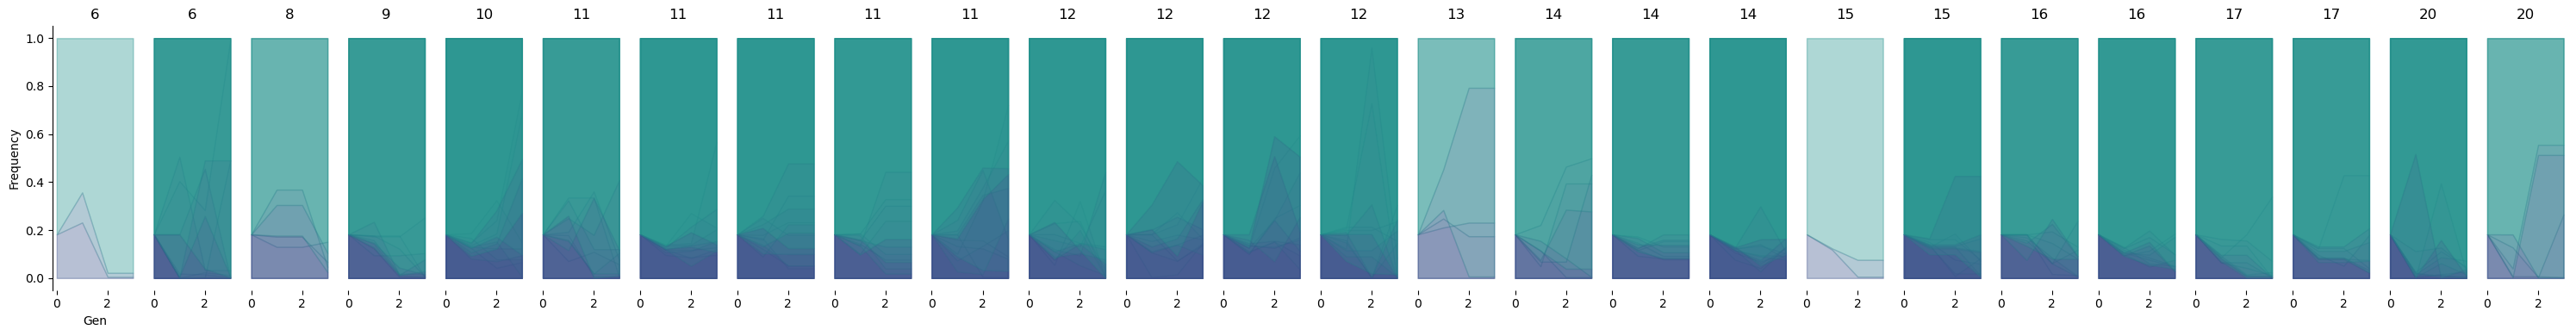

In [120]:
# Explicitly cast the values in each row to float before plotting
bio1_groups = merged_df.groupby('bio1')

# Set the number of columns for the plot grid
n_cols = len(bio1_groups)  # You can adjust this number based on your needs
n_rows = 1
# Create subplots with multiple columns

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30, 4 * n_rows), sharex=True, sharey=True)

# Flatten axes if we have multiple rows/columns
axes = axes.flatten()

# Plot each group of samples in a different subplot with color-filled areas
for i, (bio1, group) in enumerate(bio1_groups):
    # Plot each row (sample) in the group
    for _, row in group.iterrows():
        x = [0, 1, 2, 3]
        y = row[['0', '1', '2', '3']].astype(float).values  # Convert to float
        
        # Fill the area representing the alternative allele frequency
        axes[i].fill_between(x, 0, y, color=colors[0], alpha=0.2, label='Alt allele freq')
        
        # Fill the area representing the reference allele frequency
        axes[i].fill_between(x, y, 1, color=colors[1], alpha=0.2, label='Ref allele freq')
    
    # Set the title and labels for each subplot
    axes[i].set_title(f'{int(bio1)}')
    axes[i].set_xlabel('Gen')
    
    # For subplots other than the first, remove y-axis labels and ticks
    if i > 0:
        axes[i].set_ylabel('')  # Remove y-axis label
        axes[i].set_xlabel('') 
        axes[i].tick_params(left=False, labelleft=False)  # Remove y-axis ticks and labels
    
    # Remove all spines (rectangles around the plots)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].spines['left'].set_visible(i == 0)  # Only show the left spine for the first plot

# Set y-axis label and ticks only for the first plot
axes[0].set_ylabel('Frequency')
plt.subplots_adjust(wspace=0, hspace=0)  # Shrink space between subplots
# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [123]:
snps = '2_11534165'
pos = 11534165

usecols = pd.read_csv('../baypass_terminal/merged_hapFIRE_allele_frequency_indexed.csv',nrows =1).columns 
af.columns = usecols

snps_dict_filt = snps_dict_filt.reset_index(drop=True)

causal = pd.concat([af, snps_dict_filt],axis=1)

causal = causal[causal['total_alleles05filter'].notna()]

causal_det = causal[['pos', 'chrom', 'maf05filter', 'total_alleles05filter', 'block']].copy()

causal =causal.drop(['Unnamed: 745', '0','pos', 'chrom', 'maf05filter', 'total_alleles05filter', 'block'],axis=1).set_index('id')

causal_det = causal_det.reset_index(drop=True)

mask = causal_det['pos'] == pos

causal = causal.reset_index(drop=True)

pos2_606065 = causal[mask]



samples = pos2_606065.columns

#clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')
clim_sites_during_exp = pd.read_csv('../key_files/bioclimvars_sites_era5_year_2018.csv')

sites_af = pd.Series(samples).str.split('_').str[0].astype(int)

sites_af.name = 'site'

env = sites_af.reset_index().merge(clim_sites_during_exp).drop(['index'],axis=1)

pos2_606065 = pos2_606065.T.reset_index()

pos2_606065.columns = ['sample', 'af']

pos2_606065 = pd.concat([pos2_606065, env[['site', 'bio1']]],axis=1)

pos2_606065['gen'] = pos2_606065['sample'].str.split('_').str[1]
pos2_606065['plot'] = pos2_606065['sample'].str.split('_').str[2]

pos2_606065['site_plot'] = pos2_606065['site'].astype(str) + '_' + pos2_606065['plot'].astype(str)

pos2_pivot= pos2_606065.pivot_table(index = ['site_plot'], columns = 'gen', values = 'af')





p0_average_seed_mix = pd.read_csv('../key_files/p0_average_seed_mix.csv')
snps_dict = pd.read_csv('../key_files/var_pos_grenenet.csv')
p0_average_seed_mix = pd.concat([p0_average_seed_mix,snps_dict ], axis=1)
initial_freq = p0_average_seed_mix[p0_average_seed_mix['id'] == snps]['0'].values[0]

initial_freq



samples_env = pos2_606065[['site_plot', 'bio1']]

samples_env = samples_env.drop_duplicates()

# First, ensure that the 'sample' is reset as a column in pos2_pivot for merging
pos2_pivot_reset = pos2_pivot.reset_index()

# Merge pos2_pivot with samples_env based on the 'sample' column
merged_df = pos2_pivot_reset.merge(samples_env, on='site_plot')

merged_df

merged_df = merged_df.dropna(thresh=2, subset=['1', '2', '3'])

merged_df['0'] = initial_freq

merged_df['bio1_group'] = pd.cut(merged_df['bio1'], bins=10)

merged_df['bio1_group'].unique()



len(bio1_groups)

# Group by the 'bio1' column
bio1_groups = merged_df.groupby('bio1')



merged_df[['0', '1', '2', '3']] = merged_df[['0', '1', '2', '3']].fillna(method='ffill', axis=1)

bio1_groups = merged_df.groupby('bio1_group')

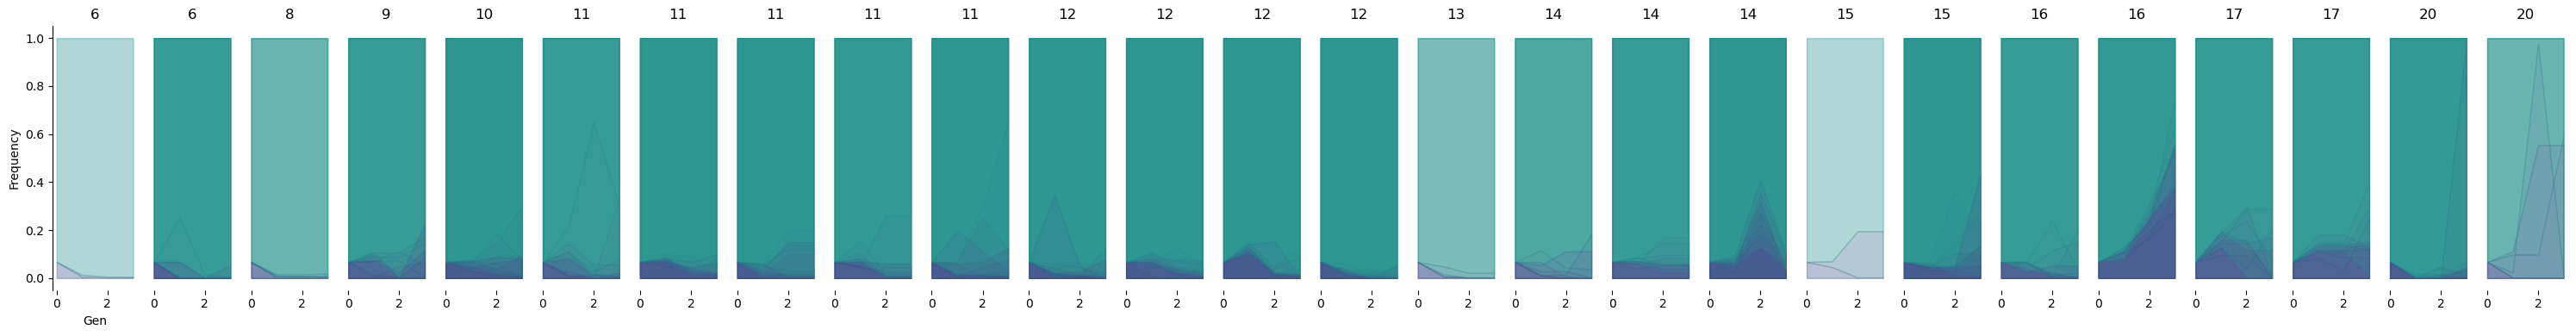

In [125]:
# Explicitly cast the values in each row to float before plotting
bio1_groups = merged_df.groupby('bio1')

# Set the number of columns for the plot grid
n_cols = len(bio1_groups)  # You can adjust this number based on your needs
n_rows = 1
# Create subplots with multiple columns

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30, 4 * n_rows), sharex=True, sharey=True)

# Flatten axes if we have multiple rows/columns
axes = axes.flatten()

# Plot each group of samples in a different subplot with color-filled areas
for i, (bio1, group) in enumerate(bio1_groups):
    # Plot each row (sample) in the group
    for _, row in group.iterrows():
        x = [0, 1, 2, 3]
        y = row[['0', '1', '2', '3']].astype(float).values  # Convert to float
        
        # Fill the area representing the alternative allele frequency
        axes[i].fill_between(x, 0, y, color=colors[0], alpha=0.2, label='Alt allele freq')
        
        # Fill the area representing the reference allele frequency
        axes[i].fill_between(x, y, 1, color=colors[1], alpha=0.2, label='Ref allele freq')
    
    # Set the title and labels for each subplot
    axes[i].set_title(f'{int(bio1)}')
    axes[i].set_xlabel('Gen')
    
    # For subplots other than the first, remove y-axis labels and ticks
    if i > 0:
        axes[i].set_ylabel('')  # Remove y-axis label
        axes[i].set_xlabel('') 
        axes[i].tick_params(left=False, labelleft=False)  # Remove y-axis ticks and labels
    
    # Remove all spines (rectangles around the plots)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].spines['left'].set_visible(i == 0)  # Only show the left spine for the first plot

# Set y-axis label and ticks only for the first plot
axes[0].set_ylabel('Frequency')
plt.subplots_adjust(wspace=0, hspace=0)  # Shrink space between subplots
# Adjust layout and show the plot
plt.tight_layout()
plt.show()


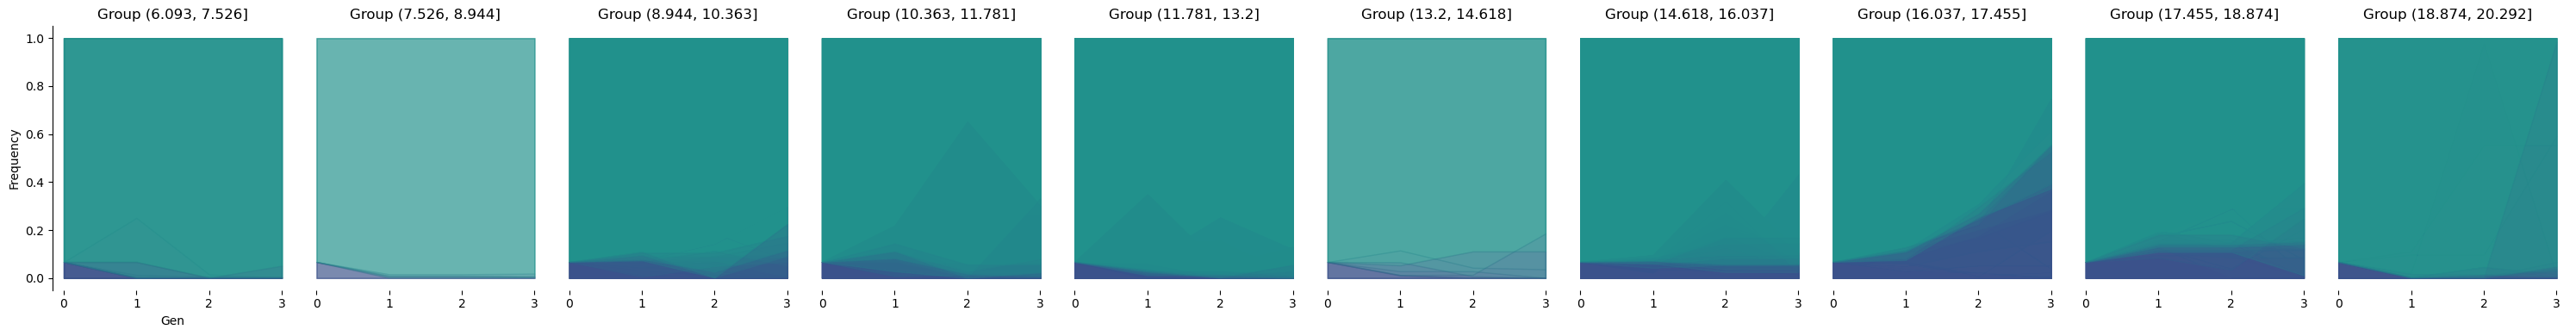

In [124]:
merged_df['bio1_group'] = pd.cut(merged_df['bio1'], bins=10)
# Explicitly cast the values in each row to float before plotting
bio1_groups = merged_df.groupby('bio1_group')

# Set the number of columns for the plot grid
n_cols = len(bio1_groups)  # You can adjust this number based on your needs
n_rows = 1
# Create subplots with multiple columns

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30, 4 * n_rows), sharex=True, sharey=True)

# Flatten axes if we have multiple rows/columns
axes = axes.flatten()

# Plot each group of samples in a different subplot with color-filled areas
for i, (bio1, group) in enumerate(bio1_groups):
    # Plot each row (sample) in the group
    for _, row in group.iterrows():
        x = [0, 1, 2, 3]
        y = row[['0', '1', '2', '3']].astype(float).values  # Convert to float
        
        # Fill the area representing the alternative allele frequency
        axes[i].fill_between(x, 0, y, color=colors[0], alpha=0.2, label='Alt allele freq')
        
        # Fill the area representing the reference allele frequency
        axes[i].fill_between(x, y, 1, color=colors[1], alpha=0.2, label='Ref allele freq')
    
    # Set the title and labels for each subplot
    axes[i].set_title(f'Group {str(bio1)}')
    axes[i].set_xlabel('Gen')
    
    # For subplots other than the first, remove y-axis labels and ticks
    if i > 0:
        axes[i].set_ylabel('')  # Remove y-axis label
        axes[i].set_xlabel('') 
        axes[i].tick_params(left=False, labelleft=False)  # Remove y-axis ticks and labels
    
    # Remove all spines (rectangles around the plots)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].spines['left'].set_visible(i == 0)  # Only show the left spine for the first plot

# Set y-axis label and ticks only for the first plot
axes[0].set_ylabel('Frequency')
plt.subplots_adjust(wspace=0, hspace=0)  # Shrink space between subplots
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [128]:
clim_sites_during_exp = pd.read_csv('../key_files/bioclimvars_sites_era5_year_2018.csv')

In [138]:
clim_sites_during_exp.sort_values('bio1').tail(10)

site       bio1       bio2       bio3        bio4       bio5       bio6  \
1      2  15.251102  17.574729  44.373954  690.033571  35.668848  -3.937109   
29    45  15.279566  21.522744  48.726341  822.793783  40.228418  -3.942236   
20    28  16.319978  23.272468  48.528985  801.958842  35.705469 -12.250342   
3      4  16.571302  19.054634  48.577053  655.652530  38.736963  -0.488623   
22    32  17.506254  11.231507  40.307936  591.227968  31.885156   4.020898   
28    43  17.982793  11.385620  43.045107  616.622639  31.109277   4.658838   
43    60  18.908464  24.535271  57.315526  659.516505  42.064600  -0.742773   
11    13  20.153398  22.374817  45.661982  835.762497  42.367578  -6.633398   
8     10  20.292248  22.322908  45.759643  834.736536  42.363672  -6.419287   
18    26  22.155024  21.154805  59.398191  532.283800  40.641504   5.026270   

         bio7       bio8       bio9      bio10      bio11        bio12  \
1   39.605957  11.622510  23.999133  24.077096   7.539410  1431.295153   
29  44.170654  12.560170  26.152377  26.152377   6.559469   535.213458   
20  47.955811  17.603766   8.363932  25.496879   6.895979  1552.055318   
3   39.225586  13.561431  24.793653  25.768012   9.856430  1056.532419   
22  27.864258  18.566795  25.062276  25.363597  10.871842   672.257426   
28  26.450439  11.098463  25.610962  25.610962  10.856560   150.441642   
43  42.807373  12.164064  26.912977  26.912977  10.511094   466.540567   
11  49.000977  18.999651  24.451598  30.809669  10.586445  1094.256948   
8   48.782959  19.206040  24.570828  30.892670  10.715132  1104.615337   
18  35.615234  15.137352  27.562259  28.068048  15.137352   122.768634   

         bio13      bio14       bio15       bio16       bio17       bio18  \
1   268.721210  21.138613   67.237519  517.957116  137.361701  160.744589   
29  121.292377   0.700880   76.496701  226.135987   18.953550   18.953550   
20  197.816486  58.389257   31.361159  478.838806  286.936265  320.298774   
3   424.618561   0.116559  130.911080  589.646135    8.215921   58.440001   
22  131.340930   1.677489   63.003182  270.996493   64.346375  100.384626   
28   33.322979   0.456262   76.253123   75.928333   10.358945   10.358945   
43  137.325507   0.038494  119.203062  249.169745    0.622671    0.622671   
11  266.263351  16.971424   83.683777  509.530576  119.736768  158.519893   
8   265.338513  16.984964   83.732801  516.047447  118.475096  168.386115   
18   31.666763   0.324824   94.033110   64.416808    2.211933    2.578514   

         bio19  
1   306.871273  
29  107.894160  
20  413.586921  
3   543.196012  
22  215.278524  
28   72.074863  
43  173.691667  
11  261.825362  
8   267.982559  
18   64.416808

In [133]:
clim_sites_during_exp[clim_sites_during_exp['site']==24]

site     bio1       bio2       bio3        bio4       bio5       bio6  \
16    24  6.10715  23.774052  49.076038  866.802113  27.357813 -21.085486   

         bio7       bio8      bio9      bio10     bio11        bio12  \
16  48.443298  15.490499 -0.978335  15.490499 -4.952381  1654.701164   

         bio13     bio14     bio15      bio16       bio17      bio18  \
16  253.419736  34.76286  46.17384  610.56325  238.980512  610.56325   

         bio19  
16  418.505085

In [132]:
merged_df['bio1'] = merged_df['bio1'].round()

In [33]:
merged_df['bio1'].unique()

array([20., 14., 13., 10.,  6., 11., 16., 15., 18.,  9., 12., 17.])

In [67]:
merged_df[merged_df['bio1']==18]

site_plot         1         2         3  bio1         0        bio1_group
134      32_1  0.175374  0.238459  0.076320  18.0  0.067175  (17.455, 18.874]
135     32_10  0.095513       NaN  0.002005  18.0  0.067175  (17.455, 18.874]
137     32_12  0.145619       NaN  0.004934  18.0  0.067175  (17.455, 18.874]
138      32_2  0.125158  0.039771  0.205314  18.0  0.067175  (17.455, 18.874]
139      32_3  0.153493  0.288650  0.289285  18.0  0.067175  (17.455, 18.874]
140      32_4  0.187311  0.295838  0.012228  18.0  0.067175  (17.455, 18.874]
142      32_6  0.197896  0.145727  0.170351  18.0  0.067175  (17.455, 18.874]
143      32_7  0.159506       NaN  0.002802  18.0  0.067175  (17.455, 18.874]
144      32_8  0.190342  0.117967       NaN  18.0  0.067175  (17.455, 18.874]
145      32_9  0.129970  0.002999       NaN  18.0  0.067175  (17.455, 18.874]
177      43_1  0.112324  0.085843       NaN  18.0  0.067175  (17.455, 18.874]
179     43_11  0.113519       NaN  0.120780  18.0  0.067175  (17.455, 18.874]
180     43_12  0.146571       NaN  0.394667  18.0  0.067175  (17.455, 18.874]
181      43_2  0.135853       NaN  0.119195  18.0  0.067175  (17.455, 18.874]
183      43_4  0.084471  0.034446  0.248816  18.0  0.067175  (17.455, 18.874]
184      43_5  0.117892       NaN  0.292931  18.0  0.067175  (17.455, 18.874]
185      43_6  0.180914       NaN  0.124547  18.0  0.067175  (17.455, 18.874]
186      43_7  0.139745       NaN  0.151807  18.0  0.067175  (17.455, 18.874]
187      43_8  0.130143       NaN  0.141766  18.0  0.067175  (17.455, 18.874]
188      43_9  0.109027       NaN  0.011669  18.0  0.067175  (17.455, 18.874]

In [37]:
pwd -P

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/follow_up_sign_blocks'

In [68]:
gemma_site_4 = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/gea_grene-net/gwas/fitness_gwas/site_32/output/results_lmm.csv')

In [ ]:
2_1265

In [69]:
sing_blocks_site_4 = gemma_site_4.groupby('blocks')['significant'].sum() [gemma_site_4.groupby('blocks')['significant'].sum() != 0]

In [76]:
sing_blocks_site_4.reset_index().head(50)

blocks  significant
0    1_162            5
1   1_1644            2
2   1_2050            1
3   1_2067            1
4   1_2170            2
5   1_2171            1
6   1_2385            1
7   1_2387            2
8   1_2407            1
9   1_3260            3
10  1_3364            1
11   1_343            2
12   1_348            1
13  1_3749            1
14   1_421            3
15   1_463            1
16    1_59            2
17   1_590            8
18   1_724           12
19    1_83            2
20   1_948            1
21   2_100            2
22  2_1225            4
23  2_1234            1
24  2_1308            1
25  2_1309            2
26  2_1313            6
27  2_1314            1
28  2_1315            2
29  2_1316            3
30   2_508            1
31   2_536            1
32   2_912            2
33   2_930            1
34   2_945            2
35  3_1230            1
36  3_2738            1
37    3_31            1
38   3_328            1
39    3_33            5
40   3_434            4
41   3_486            1
42   3_502            4
43   3_511            3
44  4_1406            1
45  4_1714            1
46  4_2112            1
47  4_2584            9
48  4_2700            2
49   4_373            2

In [71]:
sing_blocks_site_4.reset_index().sort_values('significant',ascending=False)

blocks  significant
59   5_396           13
18   1_724           12
55  5_2610            9
47  4_2584            9
17   1_590            8
..     ...          ...
37    3_31            1
36  3_2738            1
35  3_1230            1
30   2_508            1
41   3_486            1

[64 rows x 2 columns]

In [72]:
'2_1265' in sing_blocks_site_4.index

False

In [62]:
sing_blocks_site_4.reset_index().sort_values('significant',ascending=False)

blocks  significant
122  4_2826          106
45   2_1287           61
42    1_663           37
99    3_518           34
74      3_0           29
..      ...          ...
56   2_1795            1
55   2_1631            1
52   2_1553            1
49   2_1490            1
173   5_953            1

[174 rows x 2 columns]

In [46]:
11533904 - 17417133

-5883229

In [64]:
dict_blocks['2_1287'][0]

'2_12005381'

In [65]:
dict_blocks['2_1265'][0]

'2_11533904'

In [66]:
12005381 - 11533904

471477

In [93]:
merged_df

site_plot         1         2         3       bio1         0  \
1       10_10  0.097883  0.097883  0.591492  20.292248  0.067175   
4        10_2  0.023452  0.976681  0.009404  20.292248  0.067175   
7        10_5  0.002444  0.000518  0.000518  20.292248  0.067175   
10       10_8  0.002221  0.000782  0.000782  20.292248  0.067175   
11       10_9  0.110912  0.554074  0.554074  20.292248  0.067175   
..        ...       ...       ...       ...        ...       ...   
350       9_5  0.017057  0.017057  0.001199  12.665856  0.067175   
351       9_6  0.035835  0.000992  0.000521  12.665856  0.067175   
352       9_7  0.029628  0.002258  0.055451  12.665856  0.067175   
353       9_8  0.011162  0.011162  0.000576  12.665856  0.067175   
354       9_9  0.024903  0.001715  0.000000  12.665856  0.067175   

          bio1_group  
1    (19.11, 20.292]  
4    (19.11, 20.292]  
7    (19.11, 20.292]  
10   (19.11, 20.292]  
11   (19.11, 20.292]  
..               ...  
350   (12.018, 13.2]  
351   (12.018, 13.2]  
352   (12.018, 13.2]  
353   (12.018, 13.2]  
354   (12.018, 13.2]  

[248 rows x 7 columns]

/tmp/ipykernel_1591723/3859815869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['bio1_group'] = pd.cut(merged_df['bio1'], bins=10)


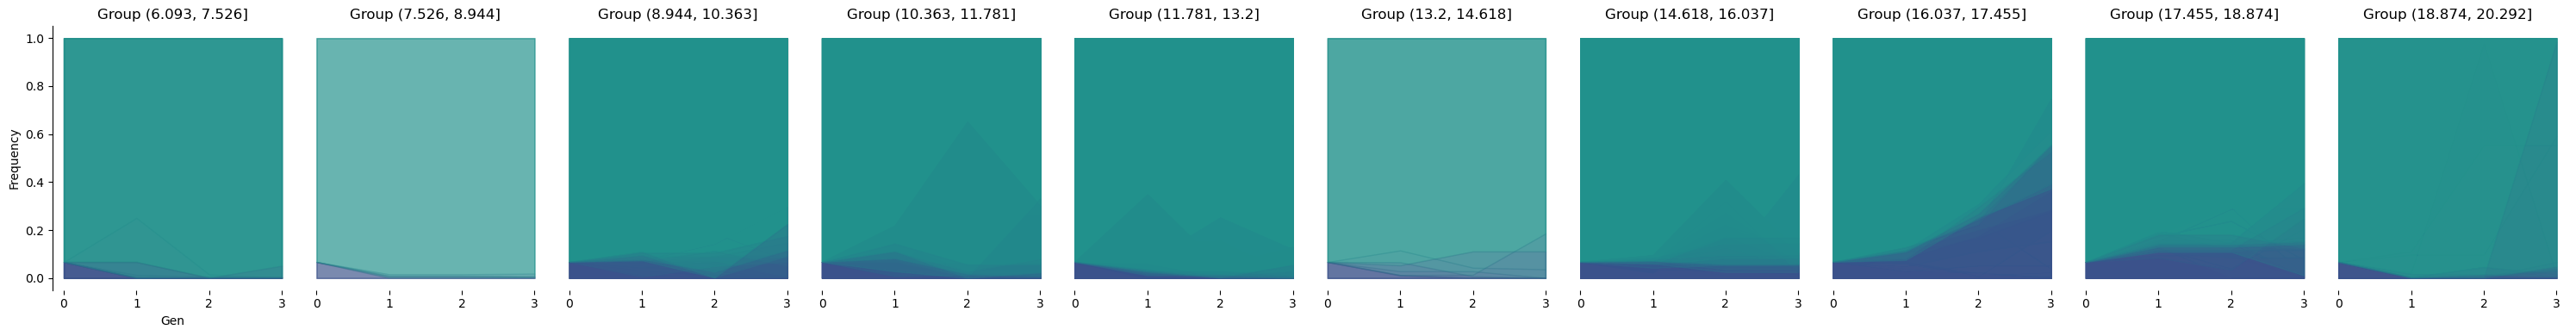

In [95]:
merged_df['bio1_group'] = pd.cut(merged_df['bio1'], bins=10)
# Explicitly cast the values in each row to float before plotting
bio1_groups = merged_df.groupby('bio1_group')

# Set the number of columns for the plot grid
n_cols = len(bio1_groups)  # You can adjust this number based on your needs
n_rows = 1
# Create subplots with multiple columns

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30, 4 * n_rows), sharex=True, sharey=True)

# Flatten axes if we have multiple rows/columns
axes = axes.flatten()

# Plot each group of samples in a different subplot with color-filled areas
for i, (bio1, group) in enumerate(bio1_groups):
    # Plot each row (sample) in the group
    for _, row in group.iterrows():
        x = [0, 1, 2, 3]
        y = row[['0', '1', '2', '3']].astype(float).values  # Convert to float
        
        # Fill the area representing the alternative allele frequency
        axes[i].fill_between(x, 0, y, color=colors[0], alpha=0.2, label='Alt allele freq')
        
        # Fill the area representing the reference allele frequency
        axes[i].fill_between(x, y, 1, color=colors[1], alpha=0.2, label='Ref allele freq')
    
    # Set the title and labels for each subplot
    axes[i].set_title(f'Group {str(bio1)}')
    axes[i].set_xlabel('Gen')
    
    # For subplots other than the first, remove y-axis labels and ticks
    if i > 0:
        axes[i].set_ylabel('')  # Remove y-axis label
        axes[i].set_xlabel('') 
        axes[i].tick_params(left=False, labelleft=False)  # Remove y-axis ticks and labels
    
    # Remove all spines (rectangles around the plots)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].spines['left'].set_visible(i == 0)  # Only show the left spine for the first plot

# Set y-axis label and ticks only for the first plot
axes[0].set_ylabel('Frequency')
plt.subplots_adjust(wspace=0, hspace=0)  # Shrink space between subplots
# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
'2_1265'

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

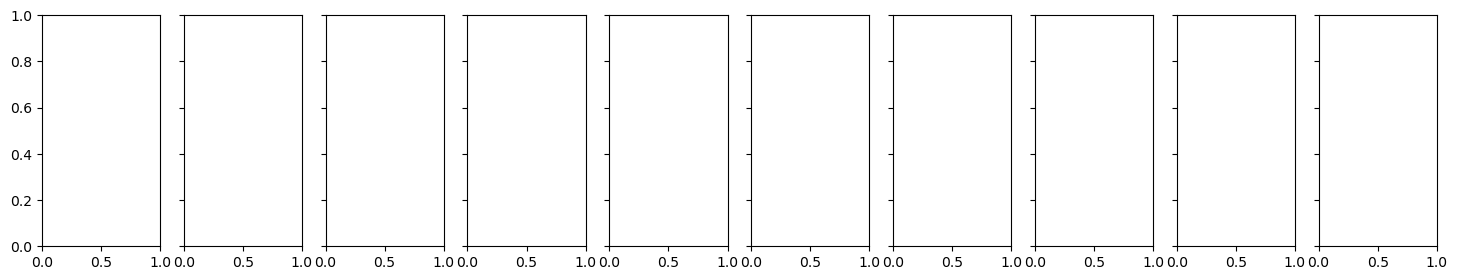

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Assuming bio1_groups is a dictionary or similar structure
# Create subplots with multiple columns
n_cols = len(bio1_groups)  # You can adjust this number based on your needs
n_rows = math.ceil(len(bio1_groups) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 3 * n_rows), sharex=True, sharey=True)

# Flatten axes if we have multiple rows/columns
axes = axes.flatten()

# Plot each group of samples in a different subplot
for i, (bio1, group) in enumerate(bio1_groups):
    # Plot each row (sample) in the group
    for _, row in group.iterrows():
        values = row[['0', '1', '2', '3']].values
        freq = values / values.sum()  # Convert to relative frequencies
        
        # Prepare the data for the stacked plot
        x = [0, 1, 2, 3]
        y1 = freq  # Frequency
        y2 = 1 - freq  # Complement of frequency

        # Plot the stacked areas
        axes[i].fill_between(x, 0, y1, color='blue', label='freq')
        axes[i].fill_between(x, y1, 1, color='orange', label='1-freq')
    
    # Set the title and labels for each subplot
    axes[i].set_title(f'Bio1')
    axes[i].set_xlabel('Gen')
    axes[i].set_ylabel('Relative Frequency')

# Remove unused subplots if there are any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [209]:
#af_filt_blocks = af_filt_blocks.drop('Unnamed: 745',axis=1)

In [19]:
causal

1_1_1     1_1_2     1_1_3     1_1_4     1_1_5     1_1_6  \
id                                                                       
2_606065   -0.053716 -0.046983 -0.091463 -0.090044 -0.064925 -0.086582   
2_606118   -0.053716 -0.046983 -0.091463 -0.090044 -0.064925 -0.086582   
2_606124    0.031364  0.006667  0.012723 -0.010902  0.009477  0.024194   
2_606166   -0.057629 -0.063906 -0.091760 -0.097366 -0.062388 -0.099643   
2_606190   -0.053716 -0.046983 -0.091463 -0.090044 -0.064925 -0.086582   
...              ...       ...       ...       ...       ...       ...   
5_19685291 -0.023648 -0.015333 -0.027204 -0.009965 -0.028725  0.011284   
5_19685375 -0.027750 -0.015519  0.010510  0.013452 -0.016344  0.027554   
5_19685384 -0.117077 -0.035809 -0.008876  0.016223  0.034097 -0.033899   
5_19685391 -0.006138 -0.015525  0.035754  0.020255  0.001753 -0.005910   
5_19685431 -0.013327 -0.011796 -0.010319  0.009269 -0.009249 -0.012417   

               1_1_7     1_1_8     1_1_9    1_1_10  ...    60_1_3    60_1_4  \
id                                                  ...                       
2_606065   -0.124436 -0.080972 -0.053968 -0.131020  ... -0.260419 -0.256477   
2_606118   -0.124436 -0.080972 -0.053968 -0.131020  ... -0.260419 -0.256477   
2_606124   -0.010332 -0.002039  0.012303  0.025621  ... -0.015498  0.313520   
2_606166   -0.124357 -0.110074 -0.060556 -0.135555  ... -0.257044 -0.252707   
2_606190   -0.124436 -0.080972 -0.053968 -0.131020  ... -0.260419 -0.256477   
...              ...       ...       ...       ...  ...       ...       ...   
5_19685291 -0.027460 -0.020514 -0.030474  0.011657  ... -0.045801  0.426635   
5_19685375  0.014634  0.016001  0.001907  0.012710  ... -0.007048  0.378586   
5_19685384 -0.004072  0.067427  0.054777  0.038217  ...  0.067504  0.244475   
5_19685391  0.027953  0.028347  0.060696 -0.011508  ... -0.008167 -0.056313   
5_19685431 -0.008440  0.004080  0.007067  0.016187  ... -0.022623  0.040147   

              60_1_5    60_1_6    60_1_7    60_1_8    60_1_9   60_1_10  \
id                                                                       
2_606065   -0.045547 -0.232248  0.187183 -0.130868 -0.120070 -0.230267   
2_606118   -0.045547 -0.232248  0.187183 -0.130868 -0.120070 -0.230267   
2_606124   -0.027005 -0.028331 -0.014963 -0.023843 -0.023846 -0.009218   
2_606166   -0.041861 -0.228342  0.190882 -0.128670 -0.116274 -0.226702   
2_606190   -0.045547 -0.232248  0.187183 -0.130868 -0.120070 -0.230267   
...              ...       ...       ...       ...       ...       ...   
5_19685291 -0.060026 -0.016837  0.080039 -0.044176 -0.048305 -0.047620   
5_19685375 -0.030178  0.043337  0.034908 -0.083717  0.346253 -0.055837   
5_19685384  0.210742  0.316421  0.004216 -0.047872  0.221585  0.306534   
5_19685391  0.020932  0.051363 -0.053020 -0.046323  0.386740 -0.016961   
5_19685431 -0.022772 -0.021689 -0.023191 -0.022903 -0.013043 -0.022986   

             60_1_11   60_1_12  
id                              
2_606065   -0.249807 -0.059618  
2_606118   -0.249807 -0.059618  
2_606124   -0.028349 -0.024980  
2_606166   -0.245825 -0.056631  
2_606190   -0.249807 -0.059618  
...              ...       ...  
5_19685291 -0.058375 -0.054268  
5_19685375  0.062181 -0.074170  
5_19685384  0.137721  0.194178  
5_19685391  0.111798 -0.028933  
5_19685431 -0.022032  0.021106  

[78 rows x 745 columns]

In [45]:
first_gen = pd.read_csv('../key_files/generation_1_sample_names.txt',header=None)[0]

In [47]:
causal_first_gen = causal[first_gen]

In [48]:
samples = causal_first_gen.columns

#clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')
clim_sites_during_exp = pd.read_csv('../key_files/bioclimvars_sites_era5_year_2018.csv')

sites_af = pd.Series(samples).str.split('_').str[0].astype(int)

sites_af.name = 'site'

env = sites_af.reset_index().merge(clim_sites_during_exp).drop(['index'],axis=1)

bio1 = env['bio1']

In [ ]:
causal_values = causal_first_gen.reset_index().drop(columns='id').T

In [49]:
bio1

0      10.209418
1      10.209418
2      10.209418
3      10.209418
4      10.209418
         ...    
321    18.908464
322    18.908464
323    18.908464
324    18.908464
325    18.908464
Name: bio1, Length: 326, dtype: float64

In [54]:
bio1

0      10.209418
1      10.209418
2      10.209418
3      10.209418
4      10.209418
         ...    
321    18.908464
322    18.908464
323    18.908464
324    18.908464
325    18.908464
Name: bio1, Length: 326, dtype: float64

In [55]:
causal_values

0           1           2           3           4   \
1_1_1     84.860414   90.256724   90.256724   90.256724   87.876052   
1_1_2    140.096628  148.440342  148.440342  148.440342  138.494160   
1_1_3    121.420890  124.278620  124.278620  124.278620  122.200860   
1_1_4    121.608636  127.110914  127.110914  127.110914  121.723384   
1_1_5    132.106036  134.645726  134.645726  134.645726  133.876392   
...             ...         ...         ...         ...         ...   
60_1_8    11.124780   11.133414   11.133414   11.133414   11.035416   
60_1_9     3.398114    3.398418    3.398418    3.398418    3.392208   
60_1_10    4.263028    5.566974    5.566974    5.566974    5.538666   
60_1_11    4.495180    4.520290    4.520290    4.520290    4.509970   
60_1_12    9.299220   12.127840   12.127840   12.127840   12.077760   

                 5           6           7           8           9   ...  \
1_1_1     90.256724   90.256724   90.256724   90.256724  186.060364  ...   
1_1_2    148.440342  148.440342  148.440342  148.440342  309.650644  ...   
1_1_3    124.278620  124.278620  124.278620  124.278620  295.851394  ...   
1_1_4    127.110914  127.110914  127.110914  127.110914  276.200494  ...   
1_1_5    134.645726  134.645726  134.645726  134.645726  275.176526  ...   
...             ...         ...         ...         ...         ...  ...   
60_1_8    11.133414   11.133414   11.133414   11.133414   28.143630  ...   
60_1_9     3.398418    3.398418    3.398418    3.398418    3.741678  ...   
60_1_10    5.566974    5.566974    5.566974    5.566974   22.185814  ...   
60_1_11    4.520290    4.520290    4.520290    4.520290   15.590040  ...   
60_1_12   12.127840   12.127840   12.127840   12.127840   25.270420  ...   

                68          69          70          71          72  \
1_1_1    31.514780   61.640722   61.807984  118.677968  104.991004   
1_1_2    36.706078   86.127956   88.719118  226.834430  199.665072   
1_1_3    44.715170  126.438948  126.696148  238.731446  214.238642   
1_1_4    56.018382  125.899614  126.779614  254.394172  216.668144   
1_1_5    59.194984  115.540372  116.155402  252.393996  231.153006   
...            ...         ...         ...         ...         ...   
60_1_8    7.530804   12.310590   12.432372   22.800174   20.525352   
60_1_9    0.226966    6.734398    6.998008   10.352578   10.133752   
60_1_10  18.255524   21.943138   22.005704   36.513568   35.696374   
60_1_11   6.580410   13.857510   13.956510   26.321510   19.474690   
60_1_12   5.036740   14.019040   14.042720   28.617880   26.632440   

                 73          74         75          76         77  
1_1_1    119.620396  180.586172  27.336430  117.794928  27.033098  
1_1_2    231.371046  268.181334  49.748866  227.797316  34.406994  
1_1_3    241.618668  293.207544  60.400144  234.316654  42.530192  
1_1_4    256.422446  283.331022  62.826318  250.105286  48.890750  
1_1_5    258.917004  270.043486  47.470938  250.670678  57.109876  
...             ...         ...        ...         ...        ...  
60_1_8    22.874148   29.024274   1.807248   22.685394   7.410090  
60_1_9    10.425948   10.562512   6.546690   10.388972   0.218036  
60_1_10   36.557822   35.698376   2.752302   34.734756  18.224738  
60_1_11   26.367500   19.759000   7.341970   26.328200   6.571890  
60_1_12   28.663580   33.586320   1.887920   28.586460   4.971220  

[326 rows x 78 columns]

In [58]:
# Create a dictionary that maps each block to a specific color
block_color_dict = {
    '2_199': 'blue',
    '3_2730': 'green',
    '5_2244': 'red'
}

In [60]:
block_rows

Index([ 31,  34,  39,  42,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  66,  67,  68,  70,  71,  72,  73,  74,  75,  77,  78,
        80,  81,  83,  84,  87,  88,  90,  92,  94,  95, 100, 102, 103, 104,
       105, 107, 113],
      dtype='int64')

In [64]:
causal_det = causal_det.reset_index(drop=True)

In [65]:
 causal_det['block'].unique()

array(['2_199', '3_2730', '5_2244'], dtype=object)

In [70]:
bio1.index = causal_values.index

0           1           2           3           4   \
1_1_1     84.860414   90.256724   90.256724   90.256724   87.876052   
1_1_2    140.096628  148.440342  148.440342  148.440342  138.494160   
1_1_3    121.420890  124.278620  124.278620  124.278620  122.200860   
1_1_4    121.608636  127.110914  127.110914  127.110914  121.723384   
1_1_5    132.106036  134.645726  134.645726  134.645726  133.876392   
...             ...         ...         ...         ...         ...   
60_1_8    11.124780   11.133414   11.133414   11.133414   11.035416   
60_1_9     3.398114    3.398418    3.398418    3.398418    3.392208   
60_1_10    4.263028    5.566974    5.566974    5.566974    5.538666   
60_1_11    4.495180    4.520290    4.520290    4.520290    4.509970   
60_1_12    9.299220   12.127840   12.127840   12.127840   12.077760   

                 5           6           7           8           9   ...  \
1_1_1     90.256724   90.256724   90.256724   90.256724  186.060364  ...   
1_1_2    148.440342  148.440342  148.440342  148.440342  309.650644  ...   
1_1_3    124.278620  124.278620  124.278620  124.278620  295.851394  ...   
1_1_4    127.110914  127.110914  127.110914  127.110914  276.200494  ...   
1_1_5    134.645726  134.645726  134.645726  134.645726  275.176526  ...   
...             ...         ...         ...         ...         ...  ...   
60_1_8    11.133414   11.133414   11.133414   11.133414   28.143630  ...   
60_1_9     3.398418    3.398418    3.398418    3.398418    3.741678  ...   
60_1_10    5.566974    5.566974    5.566974    5.566974   22.185814  ...   
60_1_11    4.520290    4.520290    4.520290    4.520290   15.590040  ...   
60_1_12   12.127840   12.127840   12.127840   12.127840   25.270420  ...   

                68          69          70          71          72  \
1_1_1    31.514780   61.640722   61.807984  118.677968  104.991004   
1_1_2    36.706078   86.127956   88.719118  226.834430  199.665072   
1_1_3    44.715170  126.438948  126.696148  238.731446  214.238642   
1_1_4    56.018382  125.899614  126.779614  254.394172  216.668144   
1_1_5    59.194984  115.540372  116.155402  252.393996  231.153006   
...            ...         ...         ...         ...         ...   
60_1_8    7.530804   12.310590   12.432372   22.800174   20.525352   
60_1_9    0.226966    6.734398    6.998008   10.352578   10.133752   
60_1_10  18.255524   21.943138   22.005704   36.513568   35.696374   
60_1_11   6.580410   13.857510   13.956510   26.321510   19.474690   
60_1_12   5.036740   14.019040   14.042720   28.617880   26.632440   

                 73          74         75          76         77  
1_1_1    119.620396  180.586172  27.336430  117.794928  27.033098  
1_1_2    231.371046  268.181334  49.748866  227.797316  34.406994  
1_1_3    241.618668  293.207544  60.400144  234.316654  42.530192  
1_1_4    256.422446  283.331022  62.826318  250.105286  48.890750  
1_1_5    258.917004  270.043486  47.470938  250.670678  57.109876  
...             ...         ...        ...         ...        ...  
60_1_8    22.874148   29.024274   1.807248   22.685394   7.410090  
60_1_9    10.425948   10.562512   6.546690   10.388972   0.218036  
60_1_10   36.557822   35.698376   2.752302   34.734756  18.224738  
60_1_11   26.367500   19.759000   7.341970   26.328200   6.571890  
60_1_12   28.663580   33.586320   1.887920   28.586460   4.971220  

[326 rows x 78 columns]

In [68]:
causal_values[row]

1_1_1      27.033098
1_1_2      34.406994
1_1_3      42.530192
1_1_4      48.890750
1_1_5      57.109876
             ...    
60_1_8      7.410090
60_1_9      0.218036
60_1_10    18.224738
60_1_11     6.571890
60_1_12     4.971220
Name: 77, Length: 326, dtype: float64

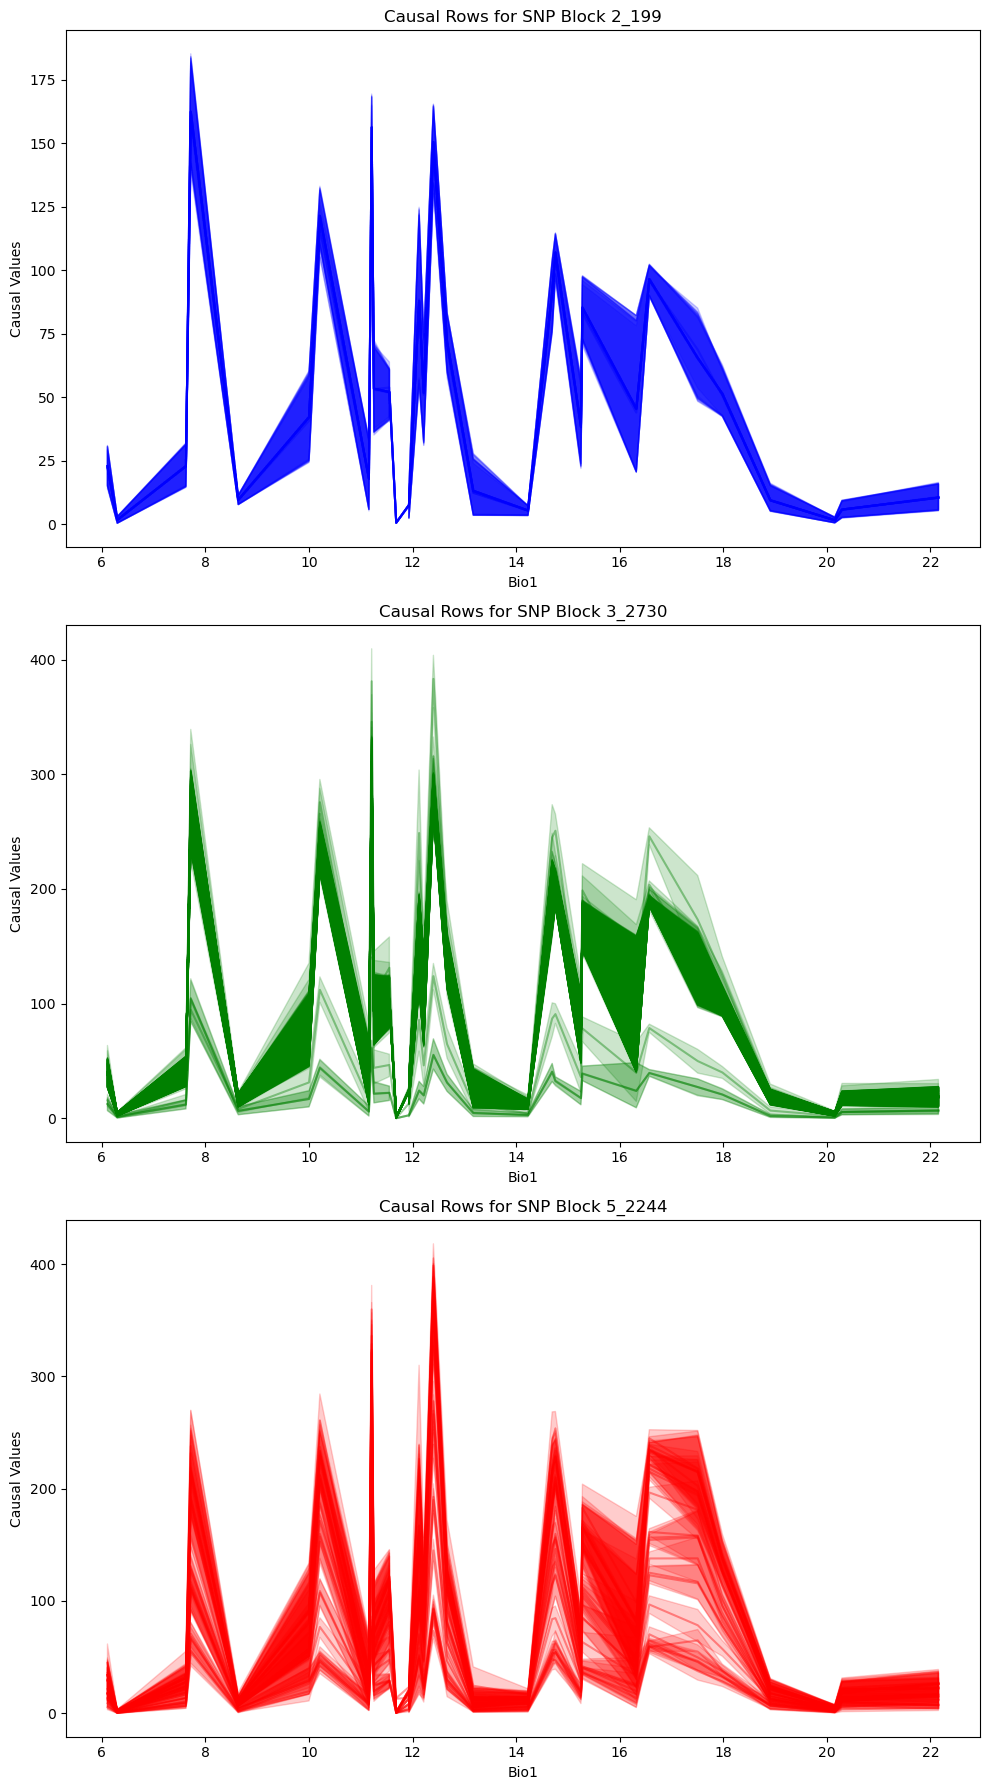

In [71]:

# Identify unique blocks from your data
unique_blocks = causal_det['block'].unique()

# Create subplots: one for each unique block
fig, axes = plt.subplots(nrows=len(unique_blocks), figsize=(10, 6 * len(unique_blocks)))

# If there's only one unique block, `axes` will not be an array, so we make it one
if len(unique_blocks) == 1:
    axes = [axes]

# Plot each row of causal as a line in the corresponding subplot
for i, block in enumerate(unique_blocks):
    # Filter the rows corresponding to the current block
    block_rows = causal_det[causal_det['block'] == block].index
    color = block_color_dict[block]
    
    for row in block_rows:
        sns.lineplot(x=bio1, y=causal_values[row], ax=axes[i], label=f'Row {row + 1}', color=color, alpha=0.4, legend=False)
    
    # Set labels and title for each subplot
    axes[i].set_title(f'Causal Rows for SNP Block {block}')
    axes[i].set_xlabel('Bio1')
    axes[i].set_ylabel('Causal Values')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_3555521/1189033000.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


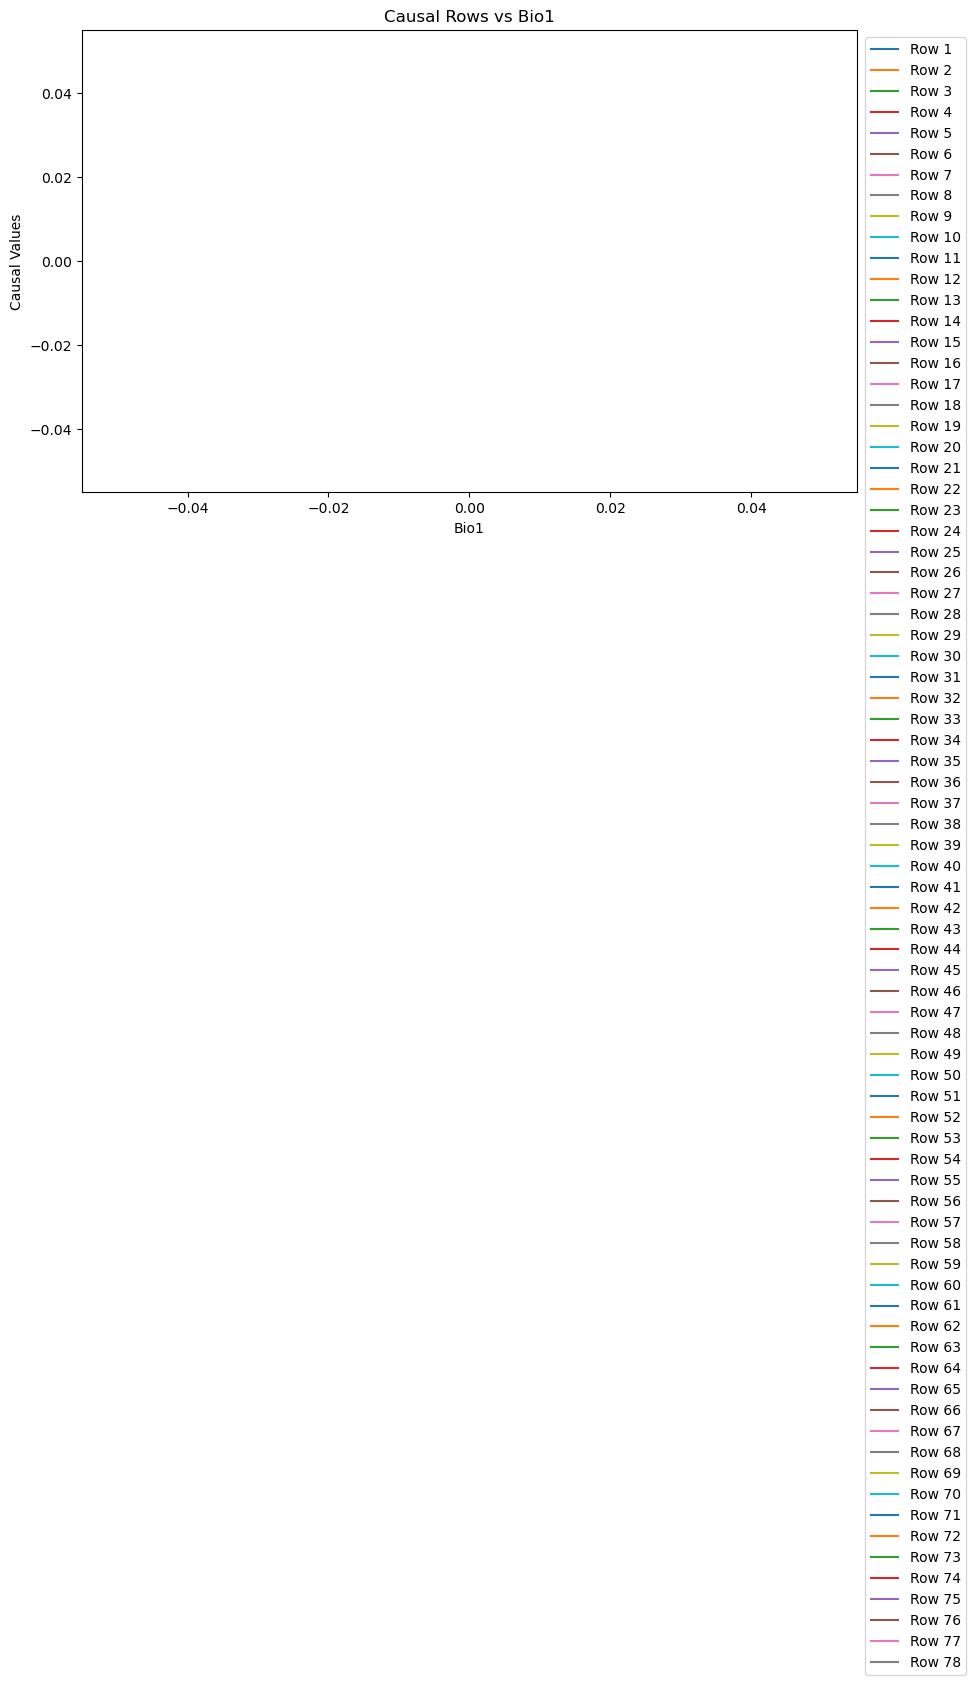

In [53]:
# Create the seaborn plot
plt.figure(figsize=(10, 6))

# Plot each row of causal as a line using seaborn
for i in range(causal_values.shape[1]):
    sns.lineplot(x=bio1, y=causal_values[i], label=f'Row {i+1}')

# Adding labels and title
plt.xlabel('Bio1')
plt.ylabel('Causal Values')
plt.title('Causal Rows vs Bio1')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Show the plot
plt.tight_layout()
plt.show()

In [118]:
## cehcking that the awk filtering is working 
#(snps_dict_filt['id'].values == af_filt_blocks['0'].values).all()

True

In [18]:
first_gen = pd.read_csv('../key_files/generation_1_sample_names.txt',header=None)[0]

In [247]:
causal_first_gen = causal[first_gen]

In [240]:
causal_loci_save = causal.index

In [248]:
causal_values = causal_first_gen.reset_index().drop(columns='id').T

In [278]:
causal_values = pd.concat([causal_values,bio1],axis=1)

In [286]:
causal_values = causal_values.groupby('bio1')[[     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,     10,     11,     12,     13,     14,     15,     16,     17,
           18,     19,     20,     21,     22,     23,     24,     25,     26,
           27,     28,     29,     30,     31,     32,     33,     34,     35,
           36,     37,     38,     39,     40,     41,     42,     43,     44,
           45,     46,     47,     48,     49,     50,     51,     52,     53,
           54,     55,     56,     57,     58,     59,     60,     61,     62,
           63,     64,     65,     66,     67,     68,     69,     70,     71,
           72,     73,     74,     75,     76,     77,]].mean()

In [295]:
causal_values = causal_values.reset_index(drop=True)

In [296]:
causal_values.shape

(31, 78)

In [251]:
samples = causal_first_gen.columns

#clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')
clim_sites_during_exp = pd.read_csv('../key_files/bioclimvars_sites_era5_year_2018.csv')

sites_af = pd.Series(samples).str.split('_').str[0].astype(int)

sites_af.name = 'site'

env = sites_af.reset_index().merge(clim_sites_during_exp).drop(['index'],axis=1)

bio1 = env['bio1']

In [292]:
bio1 =bio1.reset_index(drop=True).drop_duplicates().reset_index(drop=True)

In [252]:
bio1.index = causal_values.index

In [253]:
causal_values.shape[1]

78

In [254]:
causal_values[1]

1_1_1     -0.053716
1_1_2     -0.046983
1_1_3     -0.091463
1_1_4     -0.090044
1_1_5     -0.064925
             ...   
60_1_8    -0.130868
60_1_9    -0.120070
60_1_10   -0.230267
60_1_11   -0.249807
60_1_12   -0.059618
Name: 1, Length: 326, dtype: float64

In [257]:
causal_values[i]

1_1_1     -0.008183
1_1_2     -0.012412
1_1_3      0.005365
1_1_4     -0.013998
1_1_5     -0.013806
             ...   
60_1_8    -0.028385
60_1_9    -0.023339
60_1_10    0.165001
60_1_11   -0.006004
60_1_12   -0.032682
Name: 9, Length: 326, dtype: float64

In [261]:
causal_det = causal_det.reset_index(drop=True)

In [266]:
# Create a dictionary that maps each block to a specific color
block_color_dict = {
    '2_199': 'blue',
    '3_2730': 'green',
    '5_2244': 'red'
}

In [267]:
snp_block = causal_det.loc[i,'block']

'green'

In [269]:
snp_block[block_color_dict]

TypeError: string indices must be integers

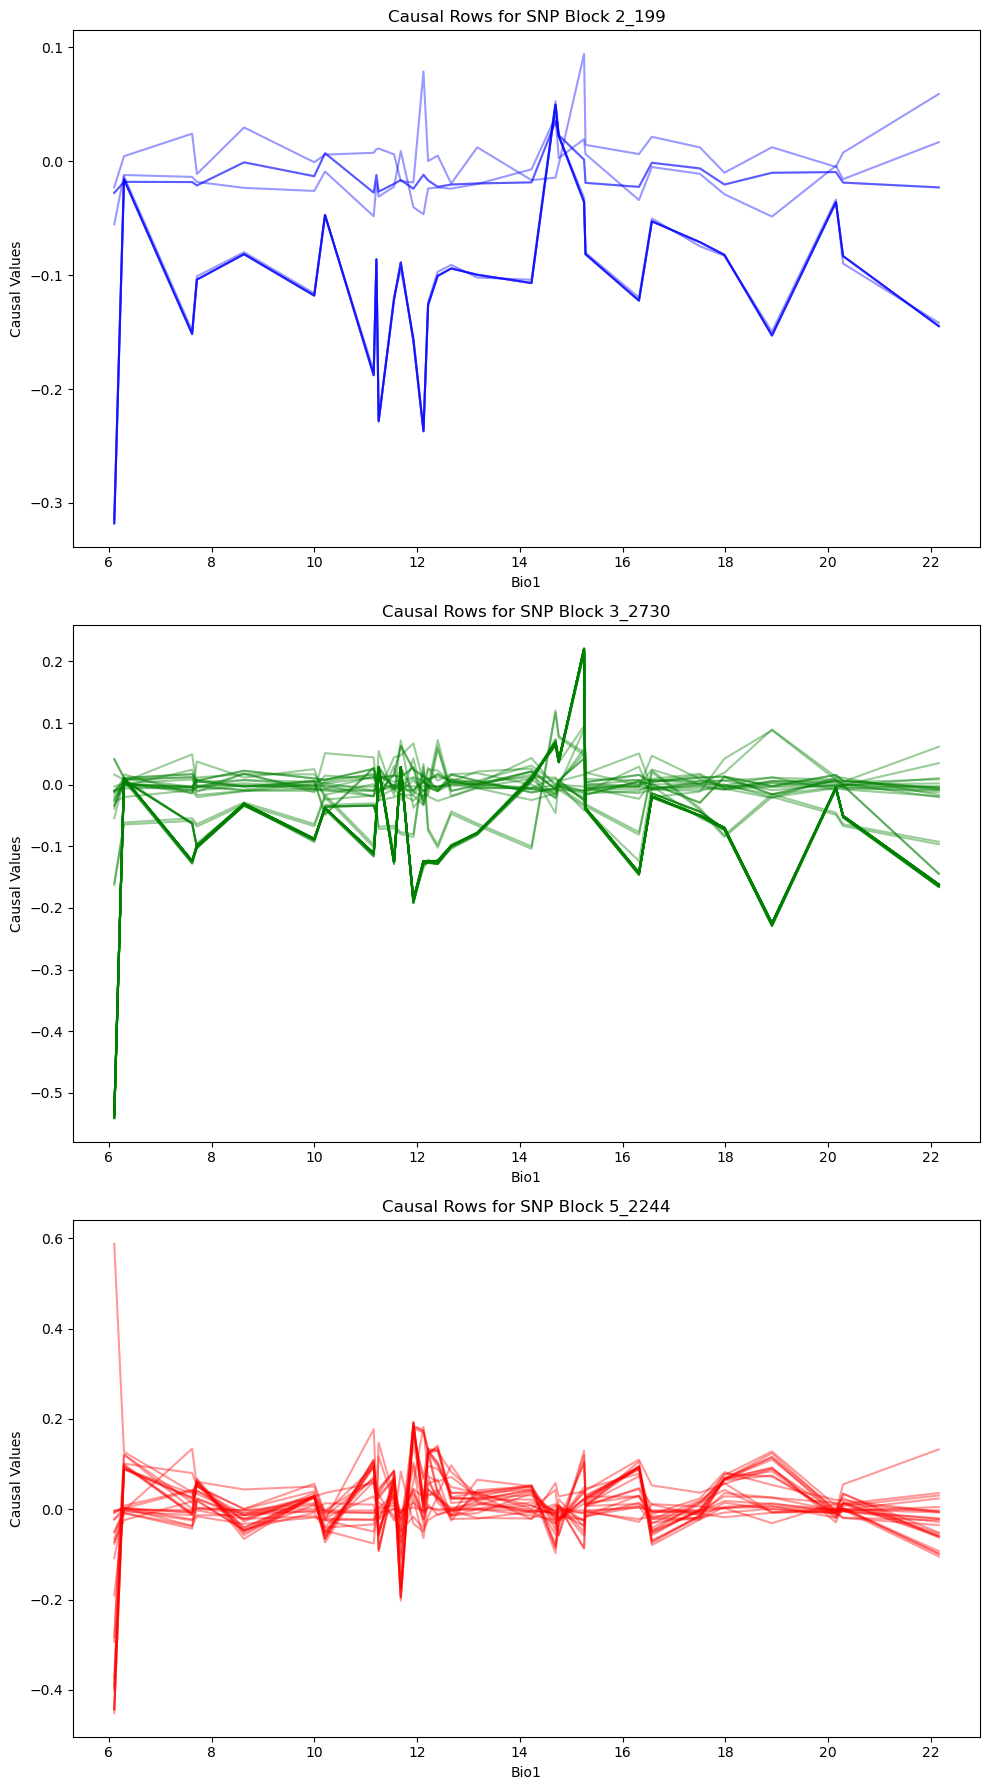

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify unique blocks from your data
unique_blocks = causal_det['block'].unique()

# Create subplots: one for each unique block
fig, axes = plt.subplots(nrows=len(unique_blocks), figsize=(10, 6 * len(unique_blocks)))

# If there's only one unique block, `axes` will not be an array, so we make it one
if len(unique_blocks) == 1:
    axes = [axes]

# Plot each row of causal as a line in the corresponding subplot
for i, block in enumerate(unique_blocks):
    # Filter the rows corresponding to the current block
    block_rows = causal_det[causal_det['block'] == block].index
    color = block_color_dict[block]
    
    for row in block_rows:
        sns.lineplot(x=bio1, y=causal_values[row], ax=axes[i], label=f'Row {row + 1}', color=color, alpha=0.4, legend=False)
    
    # Set labels and title for each subplot
    axes[i].set_title(f'Causal Rows for SNP Block {block}')
    axes[i].set_xlabel('Bio1')
    axes[i].set_ylabel('Causal Values')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


In [259]:
causal_values.shape[1]

78

/tmp/ipykernel_3504670/1189033000.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


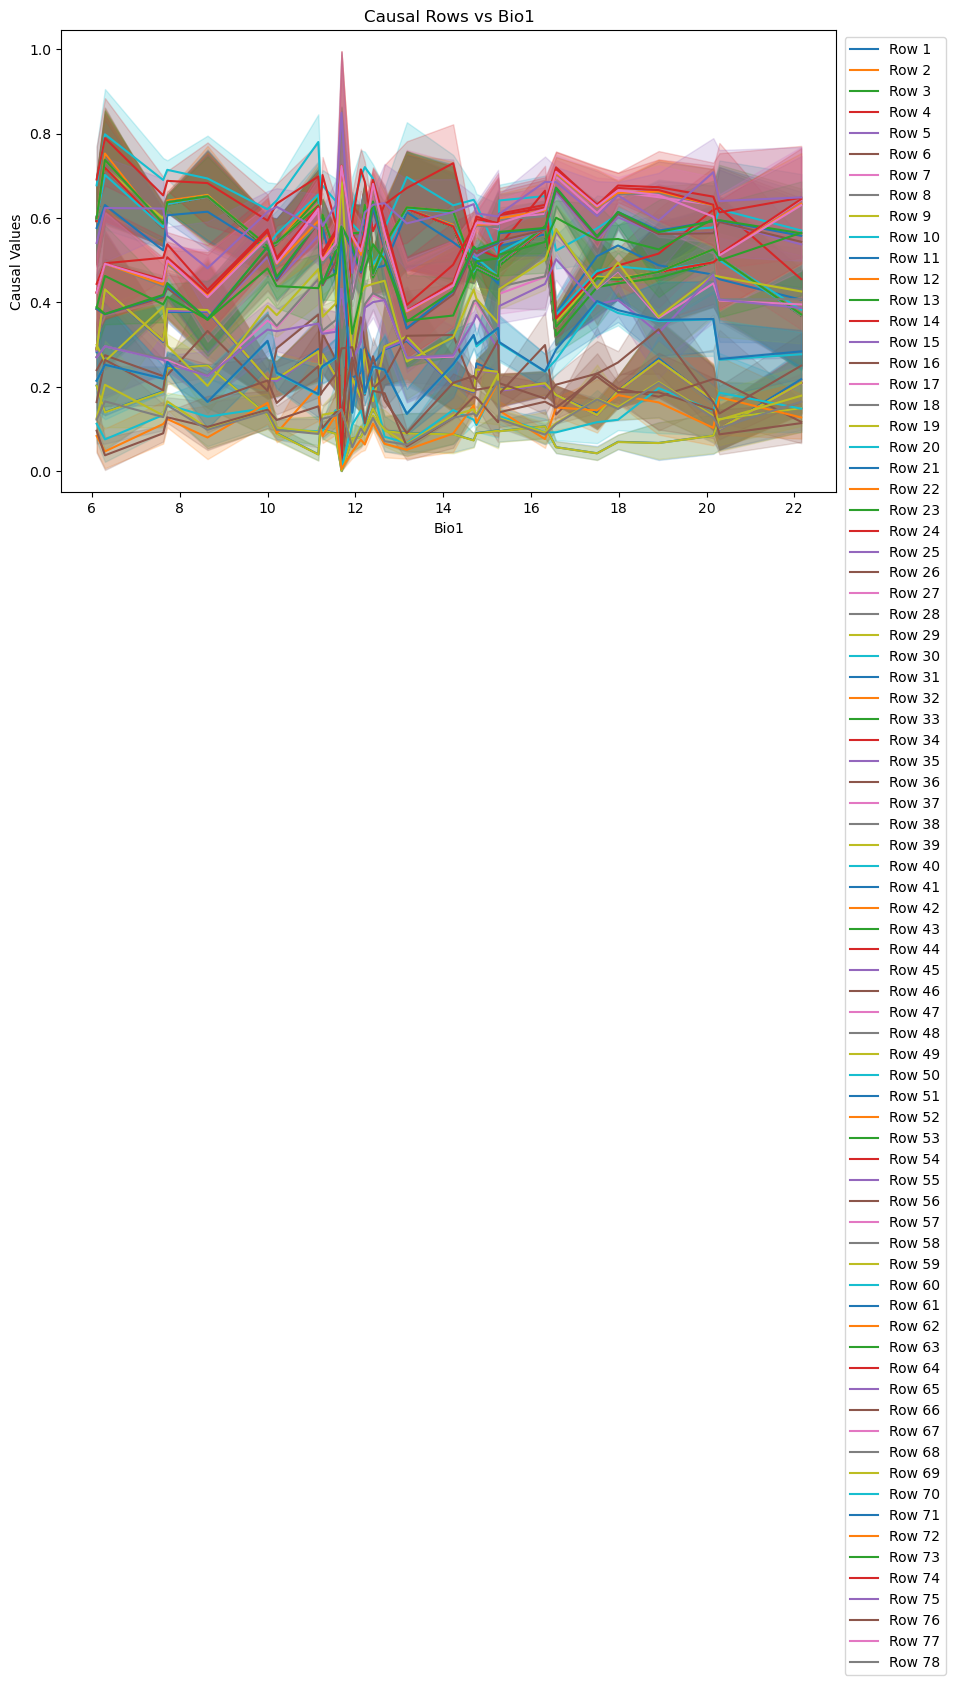

In [182]:
# Create the seaborn plot
plt.figure(figsize=(10, 6))

# Plot each row of causal as a line using seaborn
for i in range(causal_values.shape[1]):
    sns.lineplot(x=bio1, y=causal_values[i], label=f'Row {i+1}')

# Adding labels and title
plt.xlabel('Bio1')
plt.ylabel('Causal Values')
plt.title('Causal Rows vs Bio1')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Show the plot
plt.tight_layout()
plt.show()

In [169]:
# Create the seaborn plot
plt.figure(figsize=(10, 6))

# Plot each row of causal as a line using seaborn
for i in range(causal.shape[1]):
    sns.lineplot(x=bio1, y=causal[i], label=f'Row {i+1}')

# Adding labels and title
plt.xlabel('Bio1')
plt.ylabel('Causal Values')
plt.title('Causal Rows vs Bio1')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Show the plot
plt.tight_layout()
plt.show()

KeyError: 0

<Figure size 1000x600 with 0 Axes>

In [ ]:
causal = af_filt_blocks.merge(snps_dict_filt, right_on = 'id', left_on = '0')

causal.columns

causal = causal[causal['total_alleles05filter'].notna()].drop(['0', 'pos', 'chrom', 'maf05filter', 'total_alleles05filter', 'block'],axis=1).set_index('id')

samples = causal.columns

#clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')
clim_sites_during_exp = pd.read_csv('../key_files/bioclimvars_sites_era5_year_2018.csv')

sites_af = pd.Series(samples).str.split('_').str[0].astype(int)

sites_af.name = 'site'

env = sites_af.reset_index().merge(clim_sites_during_exp).drop(['index'],axis=1)

bio1 = env['bio1']

In [162]:
import seaborn as sns


KeyError: 'x'

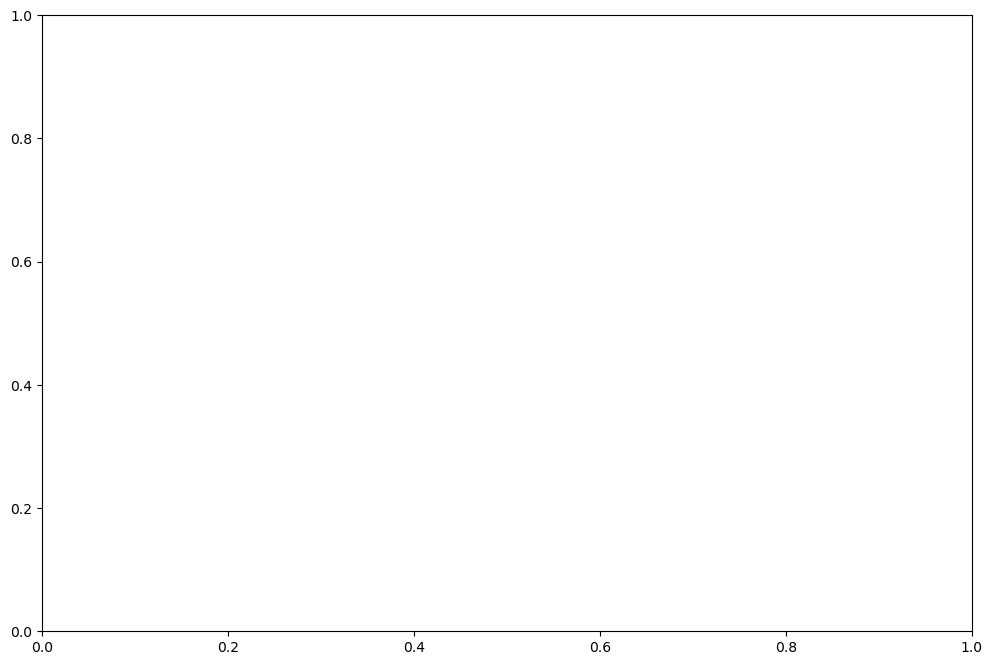

In [163]:
# Reset index to turn 'id' into a column
causal_reset = causal.reset_index()
causal_reset.rename(columns={'index': 'id'}, inplace=True)

# Melt the DataFrame to long format
causal_melted = causal_reset.melt(id_vars='id', var_name='bio1_index', value_name='value')

# Map the bio1 values
causal_melted['bio1'] = causal_melted['bio1_index'].map(bio1.to_dict())

# Create a line plot for each row in the causal DataFrame using Seaborn
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

sns.lineplot(data=causal_melted, x='bio1', y='value', hue='id', palette='tab20', alpha=0.7)

# Add labels and title
plt.xlabel('bio1')
plt.ylabel('Values from causal DataFrame')
plt.title('Line Plot of Each Row in Causal DataFrame Against bio1')
plt.legend(title='Row', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement as needed
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [141]:
import matplotlib.pyplot as plt

In [148]:
import numpy as np


In [160]:
# Reset index to turn 'id' into a column
causal_reset = causal.reset_index()
causal_reset.rename(columns={'index': 'id'}, inplace=True)

# Melt the DataFrame to long format
causal_melted = causal_reset.melt(id_vars='id', var_name='bio1_index', value_name='value')
causal_melted['bio1'] = bio1[causal_melted['bio1_index']].values

KeyError: "None of [Index(['1_1_1', '1_1_1', '1_1_1', '1_1_1', '1_1_1', '1_1_1', '1_1_1', '1_1_1',\n       '1_1_1', '1_1_1',\n       ...\n       '60_1_12', '60_1_12', '60_1_12', '60_1_12', '60_1_12', '60_1_12',\n       '60_1_12', '60_1_12', '60_1_12', '60_1_12'],\n      dtype='object', length=58110)] are in the [index]"

In [159]:

# Create a line plot for each row in the causal DataFrame using Seaborn
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

sns.lineplot(data=causal_melted, x='bio1', y='value', hue='id', palette='tab20', alpha=0.7)

# Add labels and title
plt.xlabel('bio1')
plt.ylabel('Values from causal DataFrame')
plt.title('Line Plot of Each Row in Causal DataFrame Against bio1')
plt.legend(title='Row', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement as needed
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

KeyError: "None of [Index(['1_1_1', '1_1_1', '1_1_1', '1_1_1', '1_1_1', '1_1_1', '1_1_1', '1_1_1',\n       '1_1_1', '1_1_1',\n       ...\n       '60_1_12', '60_1_12', '60_1_12', '60_1_12', '60_1_12', '60_1_12',\n       '60_1_12', '60_1_12', '60_1_12', '60_1_12'],\n      dtype='object', length=58110)] are in the [index]"

In [146]:
# Prepare the data for Seaborn
causal_melted = causal.reset_index().melt(id_vars='id', var_name='bio1_index', value_name='value')
causal_melted['bio1'] = bio1[causal_melted['bio1_index']].values

KeyError: "None of [Index(['1_1_1', '1_1_1', '1_1_1', '1_1_1', '1_1_1', '1_1_1', '1_1_1', '1_1_1',\n       '1_1_1', '1_1_1',\n       ...\n       '60_1_12', '60_1_12', '60_1_12', '60_1_12', '60_1_12', '60_1_12',\n       '60_1_12', '60_1_12', '60_1_12', '60_1_12'],\n      dtype='object', length=58110)] are in the [index]"

In [143]:


# Create a line plot for each row in the causal DataFrame using Seaborn
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

sns.lineplot(data=causal_melted, x='bio1', y='value', hue='row', palette='tab20', alpha=0.7)

# Add labels and title
plt.xlabel('bio1')
plt.ylabel('Values from causal DataFrame')
plt.title('Line Plot of Each Row in Causal DataFrame Against bio1')
plt.legend(title='Row', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement as needed
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

KeyError: 'index'

In [32]:
mask = snps_dict['block'].isin(genes).reset_index(drop=True)

In [57]:
new_mask = mask.loc[:899999]

In [35]:
ddf = dd.read_csv('../key_files/merged_hapFIRE_allele_frequency.txt', sep = '\t')

In [36]:
af = ddf.compute()


KeyboardInterrupt



In [ ]:
af = af.reset_index()

In [ ]:
af[mask]

In [ ]:



# Compute the number of NaNs per row
nan_count_per_row = ddf.isna().sum(axis=1)

# Filter the DataFrame
filtered_ddf = ddf[nan_count_per_row < 326]

f_fst = filtered_ddf.compute()

In [9]:
af = pd.read_csv('../key_files/allele_freq_maf05_mincount05_firstgensamples_windexsnpid.csv')


KeyboardInterrupt



In [ ]:
'../key_files/p0_average_seed_mix.csv'